<a href="https://colab.research.google.com/github/MaidinuerSaimi/Python-courses/blob/main/Assignment_2%2C_pair_5%2C_Max_Kolke%2C_Maidinuer_Saimi%2C_27_11_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 by pair 5, Max Kolke and Maidinuer Saimi, 27.11.2025

# 1. Introduction

In this assignment, we aim to build predictive models for 7-day mortality in ICU patients using a dataset of 1,010 patients from the UMCG ICU. The dataset contains a wide range of clinical variables measured at admission and throughout the first week of the ICU stay. Unlike previous tasks with continuous outcomes, the target variable here is binary (survivor vs. non-survivor), making this a classification problem.

Given the high number of available predictors and the potential for noisy or incomplete data, regularisation and careful cross-validation are crucial to avoid overfitting and to obtain reliable model performance estimates. We explore a variety of classical and modern classifiers, including logistic regression, tree-based ensembles, and XGBoost (among others), evaluate them using the area under the ROC curve (ROC-AUC) as the primary figure of merit, and determine the best performing model.

Note: We used ChatGPT-5.1 for code improvement and troubleshooting, and language improvement.

# 2. Preprocessing

### 2.1 Loading the dataset and inspecting the values

In [ ]:
# Cell 1
# First, we import all important libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

In [ ]:
# Cell 2
# We import the 'icu_data.csv' file.
from google.colab import files
files.upload();

Saving icu_data.csv to icu_data.csv


In [ ]:
# Cell 3
# We load the data.
df = pd.read_csv("icu_data.csv")

# We remove all columns pertaining to measurements after the first day
# of admission, and we also remove the meaningless index column.
to_remove = ["Unnamed: 0"]
for var in df.columns:
    if var.find('_d') > -1 and var.find('_d1') == -1:
        to_remove.append(var)
df = df.drop( columns = to_remove )

# We get an overview of the features in the dataset.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1010 non-null   int64  
 1   gender                  1010 non-null   int64  
 2   height                  973 non-null    float64
 3   weight                  1010 non-null   float64
 4   bsa                     973 non-null    float64
 5   diabetes_sics           1010 non-null   int64  
 6   hypertension            1010 non-null   int64  
 7   previousmi              1010 non-null   int64  
 8   previousrenalfailure    1010 non-null   int64  
 9   confirmedinfection      1010 non-null   int64  
 10  gcs_d1                  958 non-null    float64
 11  pao2_d1                 937 non-null    float64
 12  fio2_d1                 958 non-null    float64
 13  mech_vent_d1            958 non-null    object 
 14  special_vent_method_d1  957 non-null    

In [ ]:
# Cell 4
# We get an overview of the sample values.
df.describe()

,age,gender,height,weight,bsa,diabetes_sics,hypertension,previousmi,previousrenalfailure,confirmedinfection,...,cv_d1_SOFA,gcs_d1_sofa,creat_d1_SOFA,tot_d1_SOFA,max_SOFA,mort_icu,mort7,mort30,mort90,mort180
count,1010.000000,1010.000000,973.000000,1010.000000,973.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,...,939.000000,994.000000,964.000000,810.000000,916.000000,1010.000000,1009.000000,1000.000000,999.000000,999.000000
mean,60.628713,1.623762,175.591675,81.247921,1.963015,1.188119,1.305941,1.129703,1.091089,1.192079,...,1.826411,0.382294,0.475104,4.895062,6.271834,1.163366,1.133796,1.220000,0.263263,0.286286
std,15.443422,0.484681,9.974955,17.942156,0.229557,0.391001,0.461033,0.336143,0.287878,0.394130,...,1.353628,1.022766,0.805229,2.711072,2.999328,0.369883,0.340602,0.414454,0.440625,0.452251
min,18.000000,1.000000,125.000000,41.000000,1.317000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,52.000000,1.000000,169.000000,70.000000,1.810000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,3.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,64.000000,2.000000,175.000000,80.000000,1.966000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,5.000000,6.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,72.000000,2.000000,183.000000,90.250000,2.106000,1.000000,2.000000,1.000000,1.000000,1.000000,...,3.000000,0.000000,1.000000,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,2.000000,207.000000,168.000000,2.677000,2.000000,2.000000,2.000000,2.000000,2.000000,...,4.000000,4.000000,3.000000,16.000000,16.000000,2.000000,2.000000,2.000000,1.000000,1.000000


In [ ]:
# Cell 5
# We define 'mort7' as the target.
target = 'mort7'

# We identify all columns to remove: every column that contains 'mort'
# (but not 'mort7') and 'max_SOFA'.
to_drop = [col for col in df.columns if (col.startswith('mort') and col != target) or col == 'max_SOFA']

# We drop these columns.
df = df.drop(columns=to_drop)

# We check the result.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1010 non-null   int64  
 1   gender                  1010 non-null   int64  
 2   height                  973 non-null    float64
 3   weight                  1010 non-null   float64
 4   bsa                     973 non-null    float64
 5   diabetes_sics           1010 non-null   int64  
 6   hypertension            1010 non-null   int64  
 7   previousmi              1010 non-null   int64  
 8   previousrenalfailure    1010 non-null   int64  
 9   confirmedinfection      1010 non-null   int64  
 10  gcs_d1                  958 non-null    float64
 11  pao2_d1                 937 non-null    float64
 12  fio2_d1                 958 non-null    float64
 13  mech_vent_d1            958 non-null    object 
 14  special_vent_method_d1  957 non-null    

From (`df.info()`), we learn:
* `uo_d1` is a column with only 13 of 1010 values. The missing data rate is ~98.7 %, almost all values are missing.
* `MAP_d1` is a column with only 584 values. The missing rate is ~42 %.

In [ ]:
# Cell 6
# We drop the variables 'uo_d1' and 'MAP_d1' because of huge data missingness.
# Otherwise, imputation later would become unreliable.
df = df.drop(columns=['uo_d1', 'MAP_d1'], errors='ignore')

# We drop the rows where the outcome 'mort7' is missing.
df = df.dropna(subset=['mort7'])

# We check the result.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 0 to 1009
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1009 non-null   int64  
 1   gender                  1009 non-null   int64  
 2   height                  972 non-null    float64
 3   weight                  1009 non-null   float64
 4   bsa                     972 non-null    float64
 5   diabetes_sics           1009 non-null   int64  
 6   hypertension            1009 non-null   int64  
 7   previousmi              1009 non-null   int64  
 8   previousrenalfailure    1009 non-null   int64  
 9   confirmedinfection      1009 non-null   int64  
 10  gcs_d1                  957 non-null    float64
 11  pao2_d1                 936 non-null    float64
 12  fio2_d1                 957 non-null    float64
 13  mech_vent_d1            957 non-null    object 
 14  special_vent_method_d1  956 non-null    float

### 2.2 Handling missing data for numerical and categorical variables

We use imputation to fill in missing values. Numerical columns are imputed with the median (robust to outliers), categorical columns are imputed with the most frequent value. This approach ensures that all features are complete before encoding and scaling for machine learning.

In [ ]:
# Cell 7
# We import the 'SimpleImputer'.
from sklearn.impute import SimpleImputer

# we identify numerical and categorical columns.
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('mort7')  # to exclude the target
cat_cols = df.select_dtypes(include=['object']).columns

# We impute numerical columns with the median.
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# We impute categorical columns with the most frequent value.
cat_imputer = SimpleImputer(strategy='most_frequent')
if not cat_cols.empty:
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# We check for remaining missing values.
print(df.isnull().sum())

age                       0
gender                    0
height                    0
weight                    0
bsa                       0
diabetes_sics             0
hypertension              0
previousmi                0
previousrenalfailure      0
confirmedinfection        0
gcs_d1                    0
pao2_d1                   0
fio2_d1                   0
mech_vent_d1              0
special_vent_method_d1    0
sap_d1                    0
dap_d1                    0
vam_d1                    0
platelets_d1              0
bili_d1                   0
creat_d1                  0
rrt_d1                    0
resp_d1_amount            0
resp_d1_SOFA              0
platelets_d1_SOFA         0
bili_d1_SOFA              0
cv_d1_SOFA                0
gcs_d1_sofa               0
creat_d1_SOFA             0
tot_d1_SOFA               0
mort7                     0
dtype: int64


### 2.3 One-hot encoding categorical variables

In [ ]:
# Cell 8
# First, we want to identify all features with the dtype 'object' to find categorical variables.
print(df.select_dtypes(include=['object']).columns)

Index(['mech_vent_d1'], dtype='object')


So, `mech_vent_d1` is the only remaining categorical variable so far.

In [ ]:
# Cell 9
# Now, we want to inspect the values in 'mech_vent_d1' to understand its categories.
print(df['mech_vent_d1'].unique())

['1' '0' 'NIV']


The column `mech_vent_d1` contains string values `0`, `1`, and `NIV`. Machine learning models cannot process string/object values directly, so we need to convert this categorical variable into numeric dummy variables using one-hot encoding.


In [ ]:
# Cell 10
# We apply one-hot encoding to the 'mech_vent_d1' column. The 'if' command
# ensures that this cell of code can be run as often as we want.
if 'mech_vent_d1' in df.columns:
    df = pd.get_dummies(df, columns=['mech_vent_d1'], prefix='mech_vent_d1')

# We check the first few rows to ensure the dummy columns were created.
print(df.head())

    age  gender  height  weight    bsa  diabetes_sics  hypertension  \
0  31.0     2.0   167.0    65.0  1.731            1.0           1.0   
1  59.0     1.0   177.0    65.0  1.806            1.0           1.0   
2  38.0     2.0   188.0    72.5  1.976            1.0           1.0   
3  27.0     1.0   160.0    60.0  1.622            1.0           1.0   
4  51.0     2.0   182.0    86.0  2.075            1.0           1.0   

   previousmi  previousrenalfailure  confirmedinfection  ...  \
0         1.0                   1.0                 2.0  ...   
1         1.0                   1.0                 1.0  ...   
2         1.0                   1.0                 1.0  ...   
3         1.0                   1.0                 1.0  ...   
4         1.0                   1.0                 1.0  ...   

   platelets_d1_SOFA  bili_d1_SOFA  cv_d1_SOFA  gcs_d1_sofa  creat_d1_SOFA  \
0                0.0           0.0         1.0          0.0            1.0   
1                0.0           0

In [ ]:
# Cell 11
# We ensure that 'mech_vent_d1' is no longer an object type of column.
print(df.select_dtypes(include=['object']).columns)

Index([], dtype='object')


The categorical column `mech_vent_d1` has been converted into separate dummy variables for each category: `mech_vent_d1_0`, `mech_vent_d1_1`, `mech_vent_d1_NIV`. Machine learning models can now process these features directly. All other columns are numeric, and the target variable `mort7` remains separate, ready for feature-target separation.

### 2.4 Feature and target separation

Now, we split the dataset into:
* `X` (features): all columns except `mort7`
* `y` (target): the `mort7` column

In [ ]:
# Cell 12
X = df.drop('mort7', axis=1)  # all predictors：All columns except for the objective
y = df['mort7']               # the target variable

# We check the first few rows.
print(X.head())
print(y.head())

    age  gender  height  weight    bsa  diabetes_sics  hypertension  \
0  31.0     2.0   167.0    65.0  1.731            1.0           1.0   
1  59.0     1.0   177.0    65.0  1.806            1.0           1.0   
2  38.0     2.0   188.0    72.5  1.976            1.0           1.0   
3  27.0     1.0   160.0    60.0  1.622            1.0           1.0   
4  51.0     2.0   182.0    86.0  2.075            1.0           1.0   

   previousmi  previousrenalfailure  confirmedinfection  ...  resp_d1_SOFA  \
0         1.0                   1.0                 2.0  ...           2.0   
1         1.0                   1.0                 1.0  ...           2.0   
2         1.0                   1.0                 1.0  ...           0.0   
3         1.0                   1.0                 1.0  ...           0.0   
4         1.0                   1.0                 1.0  ...           1.0   

   platelets_d1_SOFA  bili_d1_SOFA  cv_d1_SOFA  gcs_d1_sofa  creat_d1_SOFA  \
0                0.0      

### 2.5 Feature scaling


Logistic regression, support vector machines, and K-nearest neighbours are sensitive to feature scales Features like `age`, `weight`, and `MAP_d1` have very different ranges. Scaling ensures that each feature contributes equally to the model.


In [ ]:
# Cell 13
from sklearn.preprocessing import StandardScaler

# We initialize the scaler. We use the 'StandardScaler()' because
# logistic regression uses a linear combination of features, and
# large-scale features can dominate small-scale ones if unscaled.
scaler = StandardScaler()

# We fit the scaler on the features 'X' and transform them.
# This centers each feature to 'mean'=0 and scales to unit variance ('stdev'=1).
X_scaled = scaler.fit_transform(X)

# We check the first few rows.
print(X_scaled[:5])

[[-1.92111548  0.77726028 -0.87503893 -0.90538474 -1.02976834 -0.48165364
  -0.66440091 -0.3862677  -0.31674462  2.04964166  0.59959762 -0.19457755
  -0.18132762 -0.05460867 -0.66083403 -0.33891473 -0.78878799 -0.49260879
  -0.27510792  0.19425023 -0.16263347 -0.27764373  0.36059401 -0.41689634
  -0.37044244 -0.58178958 -0.37079683  0.68885011 -0.37761299 -0.89902376
   0.90082747 -0.03149704]
 [-0.10673577 -1.28657031  0.14830945 -0.90538474 -0.69675244 -0.48165364
  -0.66440091 -0.3862677  -0.31674462 -0.48789016 -1.0816084  -0.27644374
  -1.141878   -0.05460867 -1.09808988 -1.3231754  -0.78878799 -0.43181548
  -0.36737958 -0.51709195 -0.16263347 -0.20809282  0.36059401 -0.41689634
  -0.37044244 -1.33826597 -0.37079683 -0.57258321  0.03429134  1.11231765
  -1.11009049 -0.03149704]
 [-1.46752055  0.77726028  1.27399266 -0.48736572  0.05808361 -0.48165364
  -0.66440091 -0.3862677  -0.31674462 -0.48789016  0.59959762  0.06466536
  -1.141878   -0.05460867  1.62635041  0.38287643  1.26776

After this preprocessing,
* the DataFrame is free of missing values,
* all numeric features are scaled,
* the categorical variable is encoded,
* and the target variable is separated.

This completes everything necessary for baseline logistic regression.

# 3. Logistic regression models

### 3.1 Baseline logistic regression


Logistic Regression is a classical linear model for binary classification. Here, we define a baseline model to evaluate predictive performance before adding regularisation or interaction terms.

In [ ]:
# Cell 14
# We import the necessary modules.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

# We define the baseline logistic regression model.
# 'max_iter'=1000 ensures convergence given the number of features.
# 'random_state'=42 ensures reproducibility.
baseline_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

# We use a stratified 5-fold cross-validation.
# StratifiedKFold maintains the same class distribution in each fold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We perform cross-validation using ROC-AUC as the scoring metric.
# 'cross_val_score' returns an array of 5 AUC scores (one per fold).
scores = cross_val_score(baseline_model, X_scaled, y, cv=skf, scoring='roc_auc')

# We print the ROC-AUC for each fold.
print("Baseline logistic regression ROC-AUC per fold:")
print(scores)

# We calculate and print the mean and the standard deviation of the AUC across the folds.
print("\nBaseline logistic regression 5-fold CV ROC-AUC:")
print(f"Mean AUC = {scores.mean():.3f}")
print(f"Stdev AUC = {scores.std():.3f}")

Baseline logistic regression ROC-AUC per fold:
[0.78666667 0.83703704 0.75746032 0.71216931 0.74946786]

Baseline logistic regression 5-fold CV ROC-AUC:
Mean AUC = 0.769
Stdev AUC = 0.042


**Results**:
* Mean AUC = 0.769: This shows that the baseline logistic regression already provides good discriminatory power for 7-day ICU mortality.
* Standard deviation ≈ 0.042: Relatively low variance of the ROC-AUC between the folds, indicating stable performance.
* Fold-wise variation: The values ​​range between ~0.72 and 0.84. This is normal and could indicate slight differences in the training and test sets, possibly also a slight class imbalance, which StratifiedKFold already partially compensates for.

### 3.2 L1-regularised logistic regression (Lasso)


L1-regularised logistic regression (Lasso) applies an L1 penalty on coefficients. This tends to shrink many coefficients exactly to zero, effectively performing feature selection. In the ICU setting, this is useful because we have many correlated predictors (e.g., overlapping SOFA components and raw lab values), and we want a more interpretable, parsimonious model.

In [ ]:
# Cell 15
# We explore a range of 'C' values (inverse of regularisation strength) on a logarithmic scale.
# Small 'C' -> strong regularisation, large 'C' -> weak regularisation.
Cs = np.logspace(-3, 2, 8)  # from 0.001 to 100

mean_auc_l1 = []
std_auc_l1 = []

print("L1-regularised logistic regression (5-fold CV, ROC-AUC):")

# We evaluate each 'C' using 5-fold cross-validation with ROC-AUC scoring.
for C in Cs:
    l1_model = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',  # 'liblinear' supports L1 penalty.
        max_iter=1000)
    scores = cross_val_score(l1_model, X_scaled, y, cv=5, scoring='roc_auc')
    mean_auc_l1.append(scores.mean())
    std_auc_l1.append(scores.std())
    print(f"C = {C:7.4f} | mean AUC = {scores.mean():.3f} | stdev = {scores.std():.3f}")

# We identify the best 'C' value based on the mean ROC-AUC.
best_idx = np.argmax(mean_auc_l1)
best_C_l1 = Cs[best_idx]
best_auc_l1 = mean_auc_l1[best_idx]

# We print the best L1 model.
print("\nThe best L1 model:")
print(f"Best 'C' = {best_C_l1:.4f} with mean ROC-AUC = {best_auc_l1:.3f}")

L1-regularised logistic regression (5-fold CV, ROC-AUC):
C =  0.0010 | mean AUC = 0.500 | stdev = 0.000
C =  0.0052 | mean AUC = 0.500 | stdev = 0.000
C =  0.0268 | mean AUC = 0.708 | stdev = 0.026
C =  0.1389 | mean AUC = 0.785 | stdev = 0.031
C =  0.7197 | mean AUC = 0.775 | stdev = 0.035
C =  3.7276 | mean AUC = 0.762 | stdev = 0.038
C = 19.3070 | mean AUC = 0.757 | stdev = 0.041
C = 100.0000 | mean AUC = 0.756 | stdev = 0.042

The best L1 model:
Best 'C' = 0.1389 with mean ROC-AUC = 0.785


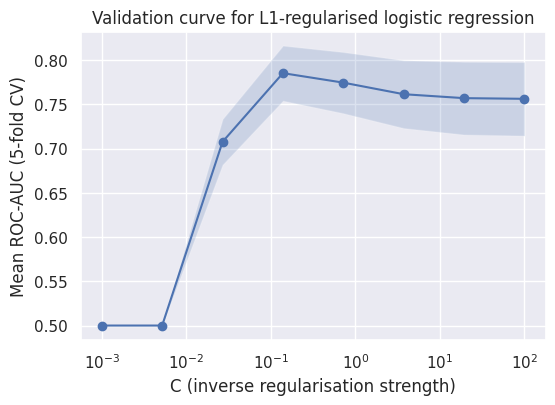

In [ ]:
# Cell 16
# We plot the validation curve ('C' vs mean ROC-AUC).
plt.figure(figsize=(6,4))
plt.semilogx(Cs, mean_auc_l1, marker='o')
plt.fill_between(
    Cs,
    np.array(mean_auc_l1) - np.array(std_auc_l1),
    np.array(mean_auc_l1) + np.array(std_auc_l1),
    alpha=0.2)

plt.xlabel("C (inverse regularisation strength)")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.title("Validation curve for L1-regularised logistic regression")
plt.grid(True)
plt.show()

**Results**:

The plot shows how the mean 5-fold CV ROC-AUC changes as we vary the inverse regularisation strength `C` for an L1-penalised logistic regression model. For very small values of `C`, the AUC is 0.5, indicating that the model is heavily underfitting due to overly strong regularisation.

As `C` increases, the performance improves rapidly and reaches its maximum around `C` ≈ 0.1, with a mean ROC-AUC of 0.785. For larger `C` values (1–100), the AUC slightly decreases and then plateaus around 0.75–0.77, suggesting little or no further benefit from weakening the regularisation.

Compared to the baseline logistic regression with default L2 penalty (mean AUC ≈ 0.769), a moderate L1 penalty (`C` ≈ 0.1) yields a small improvement in discrimination while also enforcing sparsity in the coefficients.

### 3.3 L2-regularised logistic regression (Ridge)

In contrast to the L1 penalty, which can set some coefficients exactly to zero, L2 regularisation (Ridge) shrinks all coefficients smoothly towards zero but keeps them bigger than zero. In our baseline logistic regression (section 3.1), we already used the default L2 penalty with `C` = 1.0 (inverse regularisation strength). Here, we explicitly tune `C` to see whether a stronger or weaker L2 penalty can further improve performance.

As before, we use a 5-fold cross-validation and the ROC-AUC as the figure of merit and evaluate a range of `C` values on a logarithmic scale.

In [ ]:
# Cell 17
# We define the range of 'C' values. For a fair comparison, it's the same grid as for L1.
Cs_l2 = np.logspace(-3, 2, 8)  # from 0.001 to 100

mean_auc_l2 = []
std_auc_l2 = []

print("L2-regularised Logistic Regression (5-fold CV, ROC-AUC):")
for C in Cs_l2:
    l2_model = LogisticRegression(
        penalty='l2',   # It's the default, but we set it explicitly for clarity.
        C=C,
        solver='lbfgs',
        max_iter=1000)
    scores = cross_val_score(l2_model, X_scaled, y, cv=5, scoring='roc_auc')
    mean_auc_l2.append(scores.mean())
    std_auc_l2.append(scores.std())
    print(f"C = {C:7.4f} | mean AUC = {scores.mean():.3f} | stdev = {scores.std():.3f}")

# We aim to find the best 'C'. This allows us to identify the optimal strength of L2 regularisation.
best_idx_l2 = np.argmax(mean_auc_l2)
best_C_l2 = Cs_l2[best_idx_l2]
best_auc_l2 = mean_auc_l2[best_idx_l2]

# We print the best L2 model.
print("\nThe best L2 model:")
print(f"Best 'C' = {best_C_l2:.4f} with mean ROC-AUC = {best_auc_l2:.3f}")

L2-regularised Logistic Regression (5-fold CV, ROC-AUC):
C =  0.0010 | mean AUC = 0.759 | stdev = 0.027
C =  0.0052 | mean AUC = 0.776 | stdev = 0.025
C =  0.0268 | mean AUC = 0.780 | stdev = 0.031
C =  0.1389 | mean AUC = 0.770 | stdev = 0.034
C =  0.7197 | mean AUC = 0.763 | stdev = 0.037
C =  3.7276 | mean AUC = 0.758 | stdev = 0.040
C = 19.3070 | mean AUC = 0.756 | stdev = 0.042
C = 100.0000 | mean AUC = 0.756 | stdev = 0.042

The best L2 model:
Best 'C' = 0.0268 with mean ROC-AUC = 0.780


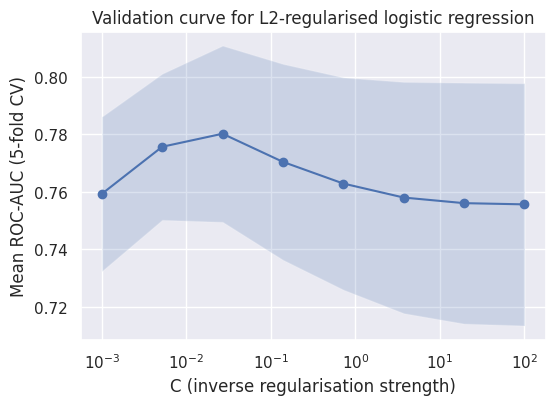

In [ ]:
# Cell 18
# We plot the validation curve for L2-regularised logistic regression.
# It shows how the mean 5-fold CV ROC-AUC changes with inverse regularisation strength 'C'.
# The shaded area represents ±1 standard deviation across folds.
plt.figure(figsize=(6, 4))
plt.semilogx(Cs_l2, mean_auc_l2, marker='o')
plt.fill_between(
    Cs_l2,
    np.array(mean_auc_l2) - np.array(std_auc_l2),
    np.array(mean_auc_l2) + np.array(std_auc_l2),
    alpha=0.2)
plt.xlabel("C (inverse regularisation strength)")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.title("Validation curve for L2-regularised logistic regression")
plt.grid(True)
plt.show()

**Result**:

The validation curve for the L2-regularised logistic regression shows a clear dependence of performance on the inverse regularisation strength `C`. For very small `Cs` (strong regularisation, e.g., `C` = 0.001), the mean 5-fold CV ROC-AUC is around 0.76, indicating a slightly underfitted model.

As `C` increases, the AUC improves and reaches a maximum of 0.780 at a moderate `C` = 0.0268. For larger values of `C` (0.1–100), the AUC gradually decreases and then plateaus around 0.756–0.763, suggesting that weaker regularisation does not provide any further benefit and may even slightly hurt performance.

Compared to the baseline logistic regression with default L2 penalty (`C` = 1.0, mean AUC ≈ 0.769), tuning `C` to a moderate value (`C` ≈ 0.027) yields a slight improvement in discrimination for 7-day ICU mortality.

### 3.4 Logistic regression with polynomial & interaction terms


In this section, we extend our previous logistic regression models by explicitly
modelling simple non-linear effects and interactions between a few clinically
important variables.

We select three continuous predictors:
* `age` (patient age),
* `sap_d1` (systolic arterial pressure on day 1),
* `tot_d1_SOFA` (total SOFA score on day 1),

and augment the feature space with:
* quadratic terms (e.g., `age²`, `sap_d1²`),
* pairwise interaction terms (e.g., `age` × `sap_d1`, `sap_d1` × `tot_d1_SOFA`).

This allows a logistic regression model to capture simple non-linear relationships and interactions, while remaining relatively interpretable.

As before, we use L2-regularised logistic regression and perform hyperparameter
tuning of the inverse regularisation strength `C` using 5-fold cross-validation
and the ROC-AUC as the performance metric.

In [ ]:
# Cell 19
# We import the necessary library.
from itertools import combinations

# Then we construct polynomial & interaction features.
# We start from the original feature matrix 'X' (after imputation and
# one-hot encoding, but before scaling).
# We create a copy so that we do not overwrite 'X' by accident.
X_poly = X.copy()

# We select a small set of clinically important continuous variables.
# For these variables, we will create quadratic and pairwise interaction terms.
important_vars = ['age', 'sap_d1', 'tot_d1_SOFA']

# 1) Quadratic terms: var^2
#    For each selected variable, we create a new column named '<var>_sq'.
for var in important_vars:
    X_poly[f'{var}_sq'] = X_poly[var] ** 2

# 2) Pairwise interaction terms: 'var_i' * 'var_j'
#    For every pair of variables in 'important_vars', we create a new column
#    named '<var1>_x_<var2>' that is the product of the two variables.
for var1, var2 in combinations(important_vars, 2):
    X_poly[f'{var1}_x_{var2}'] = X_poly[var1] * X_poly[var2]

print("Shape before polynomial / interaction features :", X.shape)
print("Shape after polynomial / interaction features  :", X_poly.shape)


# Scaling the expanded feature set

# Logistic regression with regularisation is sensitive to feature scales.
# Therefore, we standardise ALL features in 'X_poly':
#  - subtract the mean
#  - divide by the standard deviation (unit variance)
scaler_poly = StandardScaler()

# We fit the scaler on the expanded feature matrix and transform it.
# Note: During cross-validation, scaling is handled correctly inside each fold
# because 'cross_val_score' re-fits a new scaler on the training split of each fold.
# This scaler here is only used to create the fully scaled dataset (not for CV leaks).
# The result is a NumPy array with the same number of rows as 'X_poly'.
X_poly_scaled = scaler_poly.fit_transform(X_poly)


# Hyperparameter tuning for C (L2-regularised LR on X_poly)

# Now, we tune the inverse regularisation strength 'C' for an L2-regularised
# logistic regression model, using the polynomial + interaction features.
# As before, we use 5-fold cross-validation and ROC-AUC as the metric.
# We define a range of 'C' values on a logarithmic scale.
Cs_poly = np.logspace(-3, 2, 8)  # from 0.001 to 100

mean_auc_poly = []  # This is a list to store the mean AUC for each 'C'.
std_auc_poly = []   # This is a list to store the stdev of the AUC for each 'C'.

print("Logistic regression with polynomial & interaction terms")
print("L2-regularised (5-fold CV, ROC-AUC):\n")

for C in Cs_poly:
    # We define the logistic regression model with:
    #  - L2 penalty (Ridge-like)
    #  - current value of 'C' (inverse regularisation strength)
    #  - 'lbfgs' solver (supports L2 and works well for this size)
    #  - 'max_iter' increased to 1000 to ensure convergence
    logreg_poly = LogisticRegression(
        penalty='l2',
        C=C,
        solver='lbfgs',
        max_iter=1000)

    # We perform 5-fold cross-validation on the scaled polynomial features.
    # 'scoring='roc_auc'' means we use the ROC-AUC as our performance measure.
    scores = cross_val_score(
        logreg_poly,
        X_poly_scaled,
        y,
        cv=5,
        scoring='roc_auc')

    # We store the mean and the standard deviation of the AUC scores.
    mean_auc_poly.append(scores.mean())
    std_auc_poly.append(scores.std())

    # We print the results for this particular 'C'.
    print(f"C = {C:7.4f} | mean AUC = {scores.mean():.3f} | stdev = {scores.std():.3f}")

# We identify the best 'C' value based on the highest mean AUC.
best_idx_poly = np.argmax(mean_auc_poly)
best_C_poly = Cs_poly[best_idx_poly]
best_auc_poly = mean_auc_poly[best_idx_poly]

# We print the result.
print("\nThe best polynomial LR model:")
print(f"Best 'C' = {best_C_poly:.4f} with mean ROC-AUC = {best_auc_poly:.3f}")

Shape before polynomial / interaction features : (1009, 32)
Shape after polynomial / interaction features  : (1009, 38)
Logistic regression with polynomial & interaction terms
L2-regularised (5-fold CV, ROC-AUC):

C =  0.0010 | mean AUC = 0.747 | stdev = 0.022
C =  0.0052 | mean AUC = 0.771 | stdev = 0.027
C =  0.0268 | mean AUC = 0.779 | stdev = 0.030
C =  0.1389 | mean AUC = 0.772 | stdev = 0.030
C =  0.7197 | mean AUC = 0.764 | stdev = 0.031
C =  3.7276 | mean AUC = 0.757 | stdev = 0.034
C = 19.3070 | mean AUC = 0.754 | stdev = 0.034
C = 100.0000 | mean AUC = 0.754 | stdev = 0.034

The best polynomial LR model:
Best 'C' = 0.0268 with mean ROC-AUC = 0.779


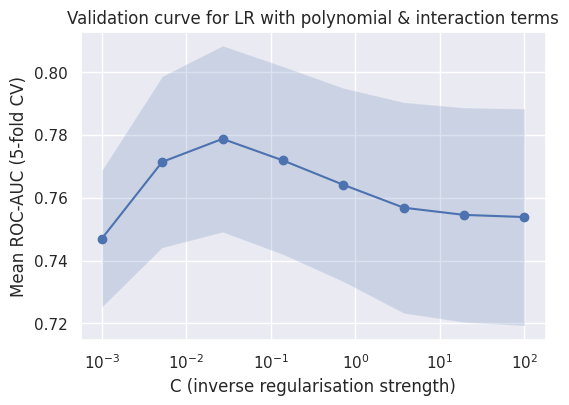

In [ ]:
# Cell 20
# Now, we plot the validation curve for polynomial LR.
plt.figure(figsize=(6, 4))
plt.semilogx(Cs_poly, mean_auc_poly, marker='o')
plt.fill_between(
    Cs_poly,
    np.array(mean_auc_poly) - np.array(std_auc_poly),
    np.array(mean_auc_poly) + np.array(std_auc_poly),
    alpha=0.2)
plt.xlabel("C (inverse regularisation strength)")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.title("Validation curve for LR with polynomial & interaction terms")
plt.grid(True)
plt.show()

**Results**:

The validation curve for the logistic regression model with polynomial and interaction terms shows a pattern similar to the purely linear L2-regularised model. For very small `C` values (strong regularisation, e.g., `C` = 0.001), the mean 5-fold CV ROC-AUC is around 0.747, indicating underfitting.

As `C` increases, performance improves and reaches a maximum of 0.779 at `C` = 0.0268. For larger `C` values (0.14–100), the AUC gradually decreases and then plateaus around 0.754–0.764, suggesting that weaker regularisation does not further improve performance.

Compared to the baseline logistic regression with default L2 penalty (`C` = 1.0, mean AUC = 0.769), the polynomial model with tuned `C` achieves a higher AUC (≈ 0.779). However, it is slightly lower than the best purely linear L1 and L2-regularised models without polynomial terms (L1: mean AUC ≈ 0.785 at `C` = 0.0268; L2: mean AUC ≈ 0.780 at `C` = 0.0268). This indicates that, in this dataset, adding quadratic and pairwise interaction terms for `age`, `sap_d1`, and `tot_d1_SOFA` provides no additional predictive value beyond the linear effects, suggesting that the linear relationships already capture most of the predictive signal.

# 4. Tree-based models

Tree-based models can naturally capture non-linear relationships and interaction
effects between predictors. Unlike logistic regression, they do not require
feature scaling and are often easier to interpret (via tree structure or feature
importance).

We start with a simple decision tree classifier.

### 4.1 The decision tree classifier


A vanilla decision tree with no constraints tends to overfit, especially when
we have many predictors. Therefore, controlling the tree complexity via
hyperparameters is crucial. We focus on:

* `max_depth`: the maximum depth of the tree (how many splits from root to leaf). Smaller values restrict the tree and reduce overfitting.
* `min_samples_leaf`: the minimum number of samples required in a leaf node. Larger values force leaves to contain more patients and make the tree smoother.

We perform a small grid search over these two hyperparameters using 5-fold cross-validation and ROC-AUC as our performance measure.

In [ ]:
# Cell 21
# We import the 'DecisionTreeClassifier'.
from sklearn.tree import DecisionTreeClassifier

# Hyperparameter tuning for DecisionTreeClassifier

# We search over a small grid of hyperparameters:
# - 'max_depth': controls how "deep" the tree can grow (model complexity).
# - 'min_samples_leaf': minimum number of samples in each leaf node (smoothness).
max_depth_values = [2, 3, 4, 5, 6, 8, 10, None]   # None = no limit on depth
min_samples_leaf_values = [1, 5, 10]

results = []  # to collect all results (for later tabulation)

print("DecisionTreeClassifier (5-fold CV, ROC-AUC):\n")

for max_depth in max_depth_values:
    for min_leaf in min_samples_leaf_values:
        # We define the decision tree with the current hyperparameters:
        # - 'random_state': fixed for reproducibility
        # - 'criterion='gini'' (default) could also be 'entropy'; we keep defaults here.
        tree_clf = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_leaf,
            random_state=42)

        # We evaluate the model using 5-fold cross-validation and the ROC-AUC.
        scores = cross_val_score(
            tree_clf,
            X,       # 'X' does not need to be scaled because
                      # we use the original feature matrix
                      # and decision trees are invariant under feature scaling.
            y,
            cv=5,
            scoring='roc_auc')

        mean_auc = scores.mean()
        std_auc = scores.std()

        # We store the result.
        results.append({
            "max_depth": max_depth,
            "min_samples_leaf": min_leaf,
            "mean_auc": mean_auc,
            "stdev_auc": std_auc})

        # We print a nicely formatted summary for this setting.
        print(f"max_depth = {str(max_depth):>4}, "
              f"min_samples_leaf = {min_leaf:2d} | "
              f"mean AUC = {mean_auc:.3f} | stdev = {std_auc:.3f}")

# We put the results in a DataFrame and find the best combination.
results_df = pd.DataFrame(results)

# We identify the row with the highest mean AUC.
best_row = results_df.loc[results_df["mean_auc"].idxmax()]

best_max_depth = best_row["max_depth"]
best_min_leaf = best_row["min_samples_leaf"]
best_auc_tree = best_row["mean_auc"]

# We print the results.
print("\nThe best decision tree model (according to 5-fold CV ROC-AUC):")
print(f"max_depth = {best_max_depth}, "
      f"min_samples_leaf = {int(best_min_leaf)} "
      f"-> mean ROC-AUC = {best_auc_tree:.3f}")

DecisionTreeClassifier (5-fold CV, ROC-AUC):

max_depth =    2, min_samples_leaf =  1 | mean AUC = 0.649 | stdev = 0.033
max_depth =    2, min_samples_leaf =  5 | mean AUC = 0.649 | stdev = 0.033
max_depth =    2, min_samples_leaf = 10 | mean AUC = 0.649 | stdev = 0.033
max_depth =    3, min_samples_leaf =  1 | mean AUC = 0.671 | stdev = 0.035
max_depth =    3, min_samples_leaf =  5 | mean AUC = 0.670 | stdev = 0.034
max_depth =    3, min_samples_leaf = 10 | mean AUC = 0.667 | stdev = 0.033
max_depth =    4, min_samples_leaf =  1 | mean AUC = 0.679 | stdev = 0.033
max_depth =    4, min_samples_leaf =  5 | mean AUC = 0.703 | stdev = 0.009
max_depth =    4, min_samples_leaf = 10 | mean AUC = 0.696 | stdev = 0.010
max_depth =    5, min_samples_leaf =  1 | mean AUC = 0.659 | stdev = 0.037
max_depth =    5, min_samples_leaf =  5 | mean AUC = 0.673 | stdev = 0.059
max_depth =    5, min_samples_leaf = 10 | mean AUC = 0.707 | stdev = 0.024
max_depth =    6, min_samples_leaf =  1 | mean AUC = 0

In [ ]:
# Cell 22
# We display the full results table sorted by performance.
results_df_sorted = results_df.sort_values("mean_auc", ascending=False)
display(results_df_sorted.head(10))

,max_depth,min_samples_leaf,mean_auc,stdev_auc
11,5.0,10,0.706633,0.024477
7,4.0,5,0.702797,0.008972
8,4.0,10,0.695998,0.010135
17,8.0,10,0.693556,0.013879
20,10.0,10,0.688244,0.014102
23,NaN,10,0.682614,0.006962
6,4.0,1,0.678782,0.032978
14,6.0,10,0.675134,0.023715
10,5.0,5,0.673104,0.059470
3,3.0,1,0.670841,0.034685


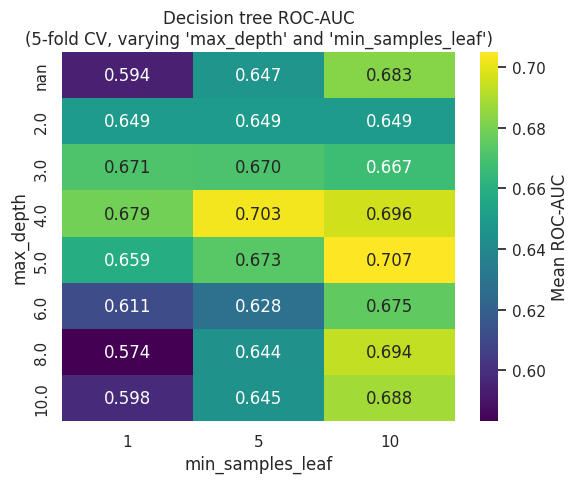

In [ ]:
# Cell 23
# We plot our results as a heatmap.
# We pivot the results into a table: rows = 'max_depth', columns = 'min_samples_leaf'.
pivot_auc = results_df.pivot(
    index="max_depth",
    columns="min_samples_leaf",
    values="mean_auc")

plt.figure(figsize=(6, 5))
sns.heatmap(
    pivot_auc,
    annot=True,        # to show numbers in each cell
    fmt=".3f",         # 3 decimal places
    cmap="viridis",     # any colormap is fine
    cbar_kws={'label': 'Mean ROC-AUC'},
    robust=True)

plt.title("Decision tree ROC-AUC\n(5-fold CV, varying 'max_depth' and 'min_samples_leaf')")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

**Results**:

The heatmap above summarises the 5-fold CV ROC-AUC of the `DecisionTreeClassifier` for different values of `max_depth` and `min_samples_leaf`.

Overall, the decision tree performs clearly worse than our logistic regression models. The best configuration reaches a mean ROC-AUC of 0.707 for `max_depth` = 5 and `min_samples_leaf` = 10.

We can observe a typical underfitting–overfitting pattern:
* Very shallow trees (`max_depth` = 2–3) achieve AUCs around 0.671–0.678, indicating underfitting.
* Increasing the depth to 4–5 improves performance, especially when leaves contain at least 5–10 samples. The best model (`max_depth` = 5, `min_samples_leaf` = 10) yields an AUC ≈ 0.707.
* For deeper trees (`max_depth` ≥ 6 or `None`), the AUC tends to drop again, particularly when `min_samples_leaf` = 1, suggesting overfitting. The tree becomes too complex and starts to model noise instead of signal.

Compared to our best logistic regression models:
* Baseline LR: 0.769
* The best L1 LR: 0.785
* The best L2 LR: 0.780
* The best polynomial LR: 0.779

the tuned decision tree is considerably weaker. This highlights an important point: despite being able to model non-linearities and interactions, single decision trees can underperform linear models when the signal is mostly additive and the data contains noise, because they are prone to high variance.

Nevertheless, decision trees provide a useful non-linear baseline and clearly illustrate how controlling tree depth and leaf size affects the bias–variance trade-off.

### 4.2 The random forest

The random forest is an ensemble of decision trees trained on bootstrap samples
of the data, with random subsets of features considered at each split. Compared
to a single decision tree, it typically has a lower variance (it is more robust and has less overfitting) and a better performance, at the cost of reduced interpretability.

Key hyperparameters that control its behaviour include:

* `n_estimators`: the number of trees in the forest (more trees -> lower variance, but higher computation time),
* `max_depth`: the maximum depth of each individual tree (controls complexity),
* `min_samples_leaf`: the minimum number of samples required in a leaf node. Larger values make the trees smoother.

We perform a small grid search over these hyperparameters using 5-fold
cross-validation and the ROC-AUC as our evaluation metric.


In [ ]:
# Cell 24
# We import the 'RandomForestClassifier'.
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter tuning for 'RandomForestClassifier'

# We define a small hyperparameter grid. See the text block above for details.
n_estimators_values = [100, 300, 500]
max_depth_values = [None, 5, 10]
min_samples_leaf_values = [1, 5]
rf_results = []

print("RandomForestClassifier (5-fold CV, ROC-AUC):\n")

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_leaf in min_samples_leaf_values:
            # We define the random forest with the current set of hyperparameters.
            # - 'n_jobs' = -1: to use all available cores
            # - 'random_state' = 42: for reproducibility
            rf_clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_leaf=min_leaf,
                n_jobs=-1,
                random_state=42)

            # We evaluate the model using 5-fold cross-validation and the ROC-AUC.
            scores = cross_val_score(
                rf_clf,
                X,       # original feature matrix (no scaling required)
                y,
                cv=5,
                scoring='roc_auc')

            mean_auc = scores.mean()
            std_auc = scores.std()

            rf_results.append({
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_leaf": min_leaf,
                "mean_auc": mean_auc,
                "stdev_auc": std_auc})

            print(
                f"n_estimators = {n_estimators:3d}, "
                f"max_depth = {str(max_depth):>4}, "
                f"min_samples_leaf = {min_leaf:2d} | "
                f"mean AUC = {mean_auc:.3f} | stdev = {std_auc:.3f}")

# We put the results into a DataFrame and find the best combination.
rf_results_df = pd.DataFrame(rf_results)

best_row_rf = rf_results_df.loc[rf_results_df["mean_auc"].idxmax()]

best_n_estimators = int(best_row_rf["n_estimators"])
best_max_depth = best_row_rf["max_depth"]
best_min_leaf = int(best_row_rf["min_samples_leaf"])
best_auc_rf = best_row_rf["mean_auc"]

# We print the results.
print("\nThe best random forest model (5-fold CV ROC-AUC):")
print(
    f"n_estimators = {best_n_estimators}, "
    f"max_depth = {best_max_depth}, "
    f"min_samples_leaf = {best_min_leaf} "
    f"-> mean ROC-AUC = {best_auc_rf:.3f}")

RandomForestClassifier (5-fold CV, ROC-AUC):

n_estimators = 100, max_depth = None, min_samples_leaf =  1 | mean AUC = 0.776 | stdev = 0.012
n_estimators = 100, max_depth = None, min_samples_leaf =  5 | mean AUC = 0.778 | stdev = 0.017
n_estimators = 100, max_depth =    5, min_samples_leaf =  1 | mean AUC = 0.772 | stdev = 0.019
n_estimators = 100, max_depth =    5, min_samples_leaf =  5 | mean AUC = 0.774 | stdev = 0.018
n_estimators = 100, max_depth =   10, min_samples_leaf =  1 | mean AUC = 0.774 | stdev = 0.012
n_estimators = 100, max_depth =   10, min_samples_leaf =  5 | mean AUC = 0.782 | stdev = 0.017
n_estimators = 300, max_depth = None, min_samples_leaf =  1 | mean AUC = 0.779 | stdev = 0.012
n_estimators = 300, max_depth = None, min_samples_leaf =  5 | mean AUC = 0.786 | stdev = 0.016
n_estimators = 300, max_depth =    5, min_samples_leaf =  1 | mean AUC = 0.777 | stdev = 0.017
n_estimators = 300, max_depth =    5, min_samples_leaf =  5 | mean AUC = 0.785 | stdev = 0.017
n_es

In [ ]:
# Cell 25
# We show the top-performing configurations.
rf_results_df_sorted = rf_results_df.sort_values("mean_auc", ascending=False)
display(rf_results_df_sorted.head(10))

,n_estimators,max_depth,min_samples_leaf,mean_auc,stdev_auc
17,500,10.0,5,0.788621,0.015468
13,500,NaN,5,0.787268,0.016394
15,500,5.0,5,0.786533,0.019149
11,300,10.0,5,0.786198,0.015778
7,300,NaN,5,0.785690,0.015534
9,300,5.0,5,0.784623,0.017086
5,100,10.0,5,0.781737,0.017097
14,500,5.0,1,0.779369,0.016517
6,300,NaN,1,0.778939,0.011973
1,100,NaN,5,0.778047,0.017024


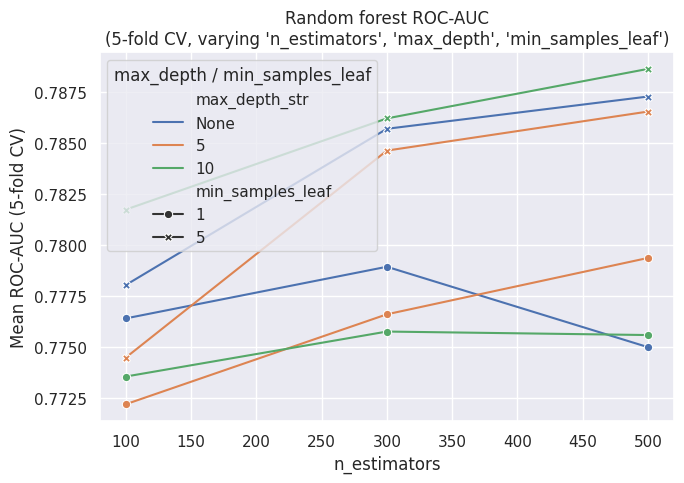

In [ ]:
# Cell 26
# We visualize the results.
# We make a copy and turn 'max_depth' into a string for nicer plotting.
rf_plot_df = rf_results_df.copy()
rf_plot_df["max_depth_str"] = rf_plot_df["max_depth"].apply(
    lambda x: "None" if pd.isna(x) else str(int(x)))

plt.figure(figsize=(7, 5))
sns.lineplot(
    data=rf_plot_df,
    x="n_estimators",
    y="mean_auc",
    hue="max_depth_str",       # colour = 'max_depth'
    style="min_samples_leaf",  # line style = 'min_samples_leaf'
    markers=True,
    dashes=False)
plt.title("Random forest ROC-AUC\n(5-fold CV, varying 'n_estimators', 'max_depth', 'min_samples_leaf')")
plt.xlabel("n_estimators")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.legend(title="max_depth / min_samples_leaf")
plt.grid(True)
plt.tight_layout()
plt.show()

**Results**:

The plot above summarises the 5-fold CV ROC-AUC of the `RandomForestClassifier` for different combinations of `n_estimators`, `max_depth`, and `min_samples_leaf`.

Overall, the random forest clearly outperforms a single decision tree and is competitive with our best logistic regression models:

* The best configuration is `n_estimators` = 500, `max_depth` = 10, and `min_samples_leaf` = 5, with a mean ROC-AUC of 0.789.
* In general, setting `min_samples_leaf` = 5 consistently yields higher AUC than `min_samples_leaf` = 1, indicating that slightly larger leaves help to regularise the trees and reduce overfitting.
* Increasing the number of trees beyond 100 leads to only marginal changes in mean AUC for the top-performing configurations.
* Allowing deeper trees (`max_depth` = None) does not substantially hurt performance, but the optimal `max_depth` for this dataset is 10.

Compared to a single decision tree (best mean ROC-AUC ≈ 0.707), the random forest achieves substantially higher performance, illustrating how ensembling reduces variance and stabilises predictions.

Compared to our current best model, which is the L1-regularised logistic regression model (mean ROC-AUC ≈ 0.785), the tuned random forest achieves a slightly higher AUC (0.789). This suggests that ensemble tree methods can capture some additional non-linear structure in the data. However, the improvement is modest, indicating that most predictive signal in this dataset is already captured by linear effects and simple interactions, and the simpler logistic regression remains a strong baseline.

### 4.3 The gradient boosting classifier (sklearn)


Gradient boosting builds an ensemble of decision trees in a sequential way:
each new tree is trained to correct the errors of the current ensemble. Compared
to a single tree, or even a random forest, gradient boosting often achieves
strong performance but can be more sensitive to hyperparameters and overfitting.

Key hyperparameters we focus on are:
* `n_estimators`: the number of boosting stages (trees). More trees can improve the performance but increase the risk of overfitting.
* `learning_rate`: the shrinkage factor applied to each tree's contribution. Smaller values require more trees but often generalise better.
* `max_depth`: the maximum depth of each individual regression tree. This controls the complexity of each base learner.

We perform a small grid search over these hyperparameters using a 5-fold
cross-validation and the ROC-AUC as our evaluation metric.

In [ ]:
# Cell 26
# First, we import the 'GradientBoostingClassifier'.
from sklearn.ensemble import GradientBoostingClassifier


# Hyperparameter tuning for the 'GradientBoostingClassifier'

# We define a small hyperparameter grid. See the text above for details.
n_estimators_values = [100, 300]
learning_rate_values = [0.05, 0.1, 0.2]
max_depth_values = [1, 3]
gb_results = []

print("GradientBoostingClassifier (5-fold CV, ROC-AUC):\n")

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            # We define the gradient boosting model with the current hyperparameters.
            # - 'n_estimators': the number of boosting stages
            # - 'learning_rate': scales the contribution of each tree.
            # - 'max_depth': the depth of the individual regression trees
            # - 'random_state': fixed for reproducibility
            gb_clf = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42)

            # We evaluate the model using a 5-fold cross-validation and the ROC-AUC.
            scores = cross_val_score(
                gb_clf,
                X,       # the original feature matrix (no scaling required)
                y,
                cv=5,
                scoring='roc_auc')

            mean_auc = scores.mean()
            std_auc = scores.std()

            gb_results.append({
                "n_estimators": n_estimators,
                "learning_rate": learning_rate,
                "max_depth": max_depth,
                "mean_auc": mean_auc,
                "stdev_auc": std_auc})

            print(
                f"n_estimators = {n_estimators:3d}, "
                f"learning_rate = {learning_rate:4.2f}, "
                f"max_depth = {max_depth:1d} | "
                f"mean AUC = {mean_auc:.3f} | stdev = {std_auc:.3f}")

# We put the results into a DataFrame and find the best combination.
gb_results_df = pd.DataFrame(gb_results)
best_row_gb = gb_results_df.loc[gb_results_df["mean_auc"].idxmax()]

best_n_estimators = int(best_row_gb["n_estimators"])
best_learning_rate = best_row_gb["learning_rate"]
best_max_depth = int(best_row_gb["max_depth"])
best_auc_gb = best_row_gb["mean_auc"]

# We print the results.
print("\nThe best gradient boosting model (5-fold CV ROC-AUC):")
print(
    f"n_estimators = {best_n_estimators}, "
    f"learning_rate = {best_learning_rate}, "
    f"max_depth = {best_max_depth} "
    f"-> mean ROC-AUC = {best_auc_gb:.3f}")

GradientBoostingClassifier (5-fold CV, ROC-AUC):

n_estimators = 100, learning_rate = 0.05, max_depth = 1 | mean AUC = 0.767 | stdev = 0.028
n_estimators = 100, learning_rate = 0.05, max_depth = 3 | mean AUC = 0.774 | stdev = 0.030
n_estimators = 100, learning_rate = 0.10, max_depth = 1 | mean AUC = 0.781 | stdev = 0.021
n_estimators = 100, learning_rate = 0.10, max_depth = 3 | mean AUC = 0.775 | stdev = 0.032
n_estimators = 100, learning_rate = 0.20, max_depth = 1 | mean AUC = 0.776 | stdev = 0.026
n_estimators = 100, learning_rate = 0.20, max_depth = 3 | mean AUC = 0.755 | stdev = 0.043
n_estimators = 300, learning_rate = 0.05, max_depth = 1 | mean AUC = 0.782 | stdev = 0.023
n_estimators = 300, learning_rate = 0.05, max_depth = 3 | mean AUC = 0.761 | stdev = 0.036
n_estimators = 300, learning_rate = 0.10, max_depth = 1 | mean AUC = 0.771 | stdev = 0.027
n_estimators = 300, learning_rate = 0.10, max_depth = 3 | mean AUC = 0.755 | stdev = 0.032
n_estimators = 300, learning_rate = 0.20

In [ ]:
# Cell 27
# We show the top-performing configurations.
gb_results_df_sorted = gb_results_df.sort_values("mean_auc", ascending=False)
display(gb_results_df_sorted.head(10))

,n_estimators,learning_rate,max_depth,mean_auc,stdev_auc
6,300,0.05,1,0.782261,0.023219
2,100,0.10,1,0.780767,0.020821
4,100,0.20,1,0.775521,0.025585
3,100,0.10,3,0.774582,0.032387
1,100,0.05,3,0.773566,0.030033
8,300,0.10,1,0.770728,0.027153
0,100,0.05,1,0.766780,0.028249
10,300,0.20,1,0.762191,0.027124
7,300,0.05,3,0.761083,0.035964
9,300,0.10,3,0.755106,0.032225


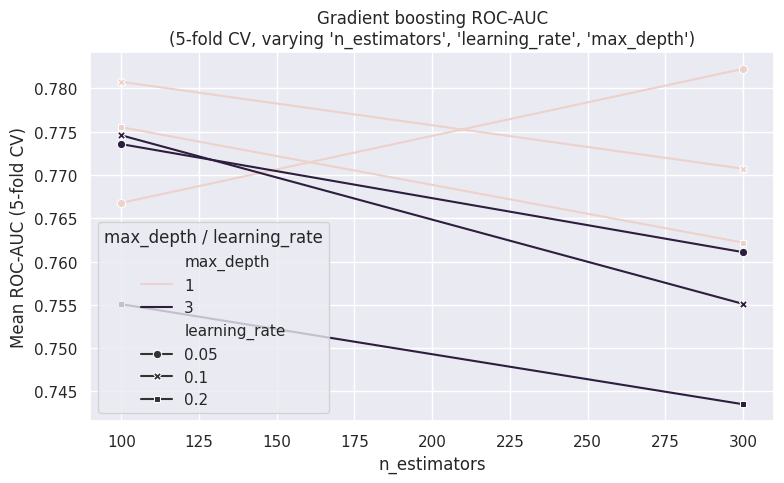

In [ ]:
# Cell 28
# We plot the results.
gb_plot_df = gb_results_df.copy()

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=gb_plot_df,
    x="n_estimators",
    y="mean_auc",
    hue="max_depth",
    style="learning_rate",
    markers=True,
    dashes=False)
plt.title("Gradient boosting ROC-AUC\n(5-fold CV, varying 'n_estimators', 'learning_rate', 'max_depth')")
plt.xlabel("n_estimators")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.legend(title="max_depth / learning_rate")
plt.grid(True)
plt.tight_layout()
plt.show()

**Results**:

The table above summarises the 5-fold CV ROC-AUC of the `GradientBoostingClassifier` for different combinations of `n_estimators`, `learning_rate`, and `max_depth`.

Overall, we observe the following patterns:
* Shallow trees (`max_depth` = 1) consistently outperform deeper trees (`max_depth` = 3).
* Deeper trees show lower mean AUCs (≈ 0.74–0.76) and higher variability, suggesting mild overfitting and less stable behaviour.
* For `max_depth` = 1, using more trees with a small learning rate improves performance:
  * 100 trees, learning rate = 0.05 → AUC ≈ 0.767
  * 300 trees, learning rate = 0.05 → AUC ≈ 0.782 (best configuration)
* Higher learning rates (0.10, 0.20) work reasonably well with 100 trees (AUC ≈ 0.776–0.781), but increasing the number of trees does not help and even slightly reduces performance at these learning rates. This indicates that too aggressive learning rates can overfit when combined with many boosting stages.

The best gradient boosting model found in our grid search is:
* `n_estimators` = 300
* `learning_rate` = 0.05
* `max_depth` = 1

with a mean 5-fold CV ROC-AUC of 0.782.

Comparison to earlier models:
* Baseline logistic regression: 0.769
* L1-regularised LR: 0.785
* L2-regularised LR: 0.780
* Polynomial LR: 0.779
* Decision tree: 0.707
* Random forest: 0.789

Gradient boosting achieves:
* almost the same performance as the best L2 logistic regression (0.782 vs. 0.780),
* slightly below the best L1 logistic regression (0.785),
* and still below the tuned random forest model (0.789, currently the best tree-based model).

This suggests that while boosting does capture some non-linear structure, the performance gains over linear models are modest, and on this dataset the random forest model remains the strongest tree-based method so far.

### 4.4 XGBoost

XGBoost ("Extreme Gradient Boosting") is an efficient and highly optimised implementation of gradient boosting. Compared to the plain
`GradientBoostingClassifier` from scikit-learn, XGBoost:
* provides additional regularisation (L1/L2),
* handles missing values internally,
* is often faster and more accurate on tabular data.

Here, we use the scikit-learn API `XGBClassifier` to build a binary classifier
for the 7-day ICU mortality.

We tune the following key hyperparameters:
* `n_estimators`: the number of boosting rounds (trees).
* `learning_rate` (eta): the step size / shrinkage applied to each tree.
* `max_depth`: the maximum depth of individual trees.
* `subsample`: the fraction of samples used for each tree (row subsampling).
* `colsample_bytree`: the fraction of features used for each tree (column subsampling).

As before, we use 5-fold cross-validation and the ROC-AUC as our evaluation metric.


In [ ]:
# Cell 29
# First, we need to install XGBoost.
!pip install xgboost

# XGBoost requires binary classification labels to be [0, 1], so we need to map 'y' from {1,2} to {0,1}.
# '0' = survivors, '1' = non-survivors (7-day mortality)
print("\nOriginal labels in y:", sorted(y.unique()))
y_bin = (y == 2).astype(int)
print("Labels after recoding:", sorted(y_bin.unique()))


Original labels in y: [np.float64(1.0), np.float64(2.0)]
Labels after recoding: [np.int64(0), np.int64(1)]


In [ ]:
# Cell 30
# XGBoost hyperparameter tuning ('C'-like parameters)
# We import the 'XGBClassifier'.
from xgboost import XGBClassifier

# Like in the previous sectinos, we define a small but reasonable hyperparameter grid:
# See the text above for details.
n_estimators_values = [200, 400]
learning_rate_values = [0.05, 0.1]
max_depth_values = [3, 5]
subsample_values = [0.8, 1.0]
colsample_values = [0.8, 1.0]

xgb_results = []

print("XGBClassifier (5-fold CV, ROC-AUC):\n")

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            for subsample in subsample_values:
                for colsample in colsample_values:
                    # We define the 'XGBClassifier' with the current hyperparameters.
                    # Important arguments:
                    #  - 'objective'='binary:logistic': binary classification with
                    #    probabilistic outputs (sigmoid at the end)
                    #  - 'eval_metric'='logloss': to avoid deprecation warnings and
                    #    sets a sensible default training metric
                    #  - 'n_jobs'=-1: to use all available CPU cores
                    #  - 'random_state'=42: for reproducibility
                    xgb_clf = XGBClassifier(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        n_jobs=-1,
                        random_state=42,)
                        # The 'use_label_encoder' is deprecated in recent versions;
                        # we rely on the default behaviour.

                    # We evaluate the model with a 5-fold cross-validation using the ROC-AUC.
                    # Important: we now use 'y_bin' (0/1 labels), not the original 'y' (1/2).
                    scores = cross_val_score(
                        xgb_clf,
                        X,          # The original feature matrix (trees don't need scaling)
                        y_bin,      # recoded binary labels
                        cv=5,
                        scoring='roc_auc')

                    mean_auc = scores.mean()
                    std_auc = scores.std()

                    xgb_results.append({
                        "n_estimators": n_estimators,
                        "learning_rate": learning_rate,
                        "max_depth": max_depth,
                        "subsample": subsample,
                        "colsample_bytree": colsample,
                        "mean_auc": mean_auc,
                        "stdev_auc": std_auc})

                    print(
                        f"n_estimators = {n_estimators:3d}, "
                        f"learning_rate = {learning_rate:4.2f}, "
                        f"max_depth = {max_depth:1d}, "
                        f"subsample = {subsample:3.1f}, "
                        f"colsample_bytree = {colsample:3.1f} | "
                        f"mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}")


# We collect results in a DataFrame and find the best configuration.
xgb_results_df = pd.DataFrame(xgb_results)

best_row_xgb = xgb_results_df.loc[xgb_results_df["mean_auc"].idxmax()]

best_n_estimators = int(best_row_xgb["n_estimators"])
best_learning_rate = best_row_xgb["learning_rate"]
best_max_depth = int(best_row_xgb["max_depth"])
best_subsample = best_row_xgb["subsample"]
best_colsample = best_row_xgb["colsample_bytree"]
best_auc_xgb = best_row_xgb["mean_auc"]

# We print the results.
print("\nThe best XGBoost model (5-fold CV ROC-AUC):")
print(
    f"n_estimators = {best_n_estimators}, "
    f"learning_rate = {best_learning_rate}, "
    f"max_depth = {best_max_depth}, "
    f"subsample = {best_subsample}, "
    f"colsample_bytree = {best_colsample} "
    f"-> mean ROC-AUC = {best_auc_xgb:.3f}")

XGBClassifier (5-fold CV, ROC-AUC):

n_estimators = 200, learning_rate = 0.05, max_depth = 3, subsample = 0.8, colsample_bytree = 0.8 | mean AUC = 0.774 | std = 0.027
n_estimators = 200, learning_rate = 0.05, max_depth = 3, subsample = 0.8, colsample_bytree = 1.0 | mean AUC = 0.780 | std = 0.025
n_estimators = 200, learning_rate = 0.05, max_depth = 3, subsample = 1.0, colsample_bytree = 0.8 | mean AUC = 0.786 | std = 0.029
n_estimators = 200, learning_rate = 0.05, max_depth = 3, subsample = 1.0, colsample_bytree = 1.0 | mean AUC = 0.778 | std = 0.030
n_estimators = 200, learning_rate = 0.05, max_depth = 5, subsample = 0.8, colsample_bytree = 0.8 | mean AUC = 0.780 | std = 0.019
n_estimators = 200, learning_rate = 0.05, max_depth = 5, subsample = 0.8, colsample_bytree = 1.0 | mean AUC = 0.775 | std = 0.025
n_estimators = 200, learning_rate = 0.05, max_depth = 5, subsample = 1.0, colsample_bytree = 0.8 | mean AUC = 0.772 | std = 0.029
n_estimators = 200, learning_rate = 0.05, max_depth =

In [ ]:
# Cell 31
# We show the top-performing configurations.
xgb_results_df_sorted = xgb_results_df.sort_values("mean_auc", ascending=False)
display(xgb_results_df_sorted.head(10))

,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,mean_auc,stdev_auc
2,200,0.05,3,1.0,0.8,0.785624,0.029095
4,200,0.05,5,0.8,0.8,0.780310,0.018533
1,200,0.05,3,0.8,1.0,0.779834,0.025228
20,400,0.05,5,0.8,0.8,0.778119,0.019713
3,200,0.05,3,1.0,1.0,0.777827,0.029784
5,200,0.05,5,0.8,1.0,0.774919,0.025368
0,200,0.05,3,0.8,0.8,0.774100,0.026607
21,400,0.05,5,0.8,1.0,0.772556,0.017846
10,200,0.10,3,1.0,0.8,0.772291,0.037878
6,200,0.05,5,1.0,0.8,0.771922,0.029459


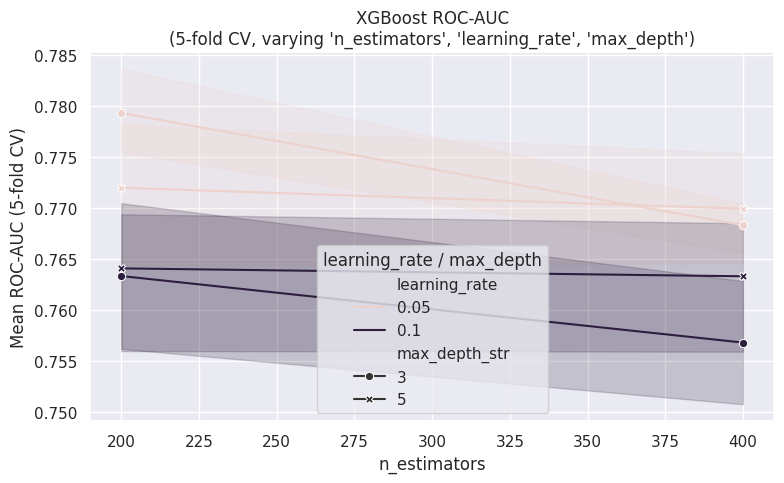

In [ ]:
# Cell 32
# We plot our results.
xgb_plot_df = xgb_results_df.copy()
xgb_plot_df["max_depth_str"] = xgb_plot_df["max_depth"].astype(int).astype(str)

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=xgb_plot_df,
    x="n_estimators",
    y="mean_auc",
    hue="learning_rate",      # colour: learning_rate
    style="max_depth_str",    # line: max_depth
    markers=True,
    dashes=False)
plt.title("XGBoost ROC-AUC\n(5-fold CV, varying 'n_estimators', 'learning_rate', 'max_depth')")
plt.xlabel("n_estimators")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.legend(title="learning_rate / max_depth")
plt.grid(True)
plt.tight_layout()
plt.show()

**Results**:

The table above summarises the 5-fold cross-validated ROC-AUC scores obtained from tuning the XGBoost classifier across different values of `n_estimators`, `learning_rate`, `max_depth`, `subsample`, and `colsample_bytree`.

We observe several clear trends:
* The `learning rate`: A smaller `learning rate` of 0.05 consistently outperforms 0.10 across almost all configurations. For instance, with `n_estimators` = 200 and `max_depth` = 3, AUC values range from 0.778–0.786 when using `learning_rate` = 0.05, whereas `learning_rate` = 0.10 typically yields lower performance (≈0.752–0.772).
* The number of boosting rounds (`n_estimators`): Increasing the number of trees from 200 to 400 does not improve performance. The AUC often decreases slightly at 400 estimators, indicating that 200 trees are sufficient and that adding more trees does not yield additional benefits at these learning rates.
* The tree depth (`max_depth`): Both `max_depth` = 3 and `max_depth` = 5 produce competitive results, but the best model uses `max_depth` = 3, indicating that relatively shallow trees generalise better for this dataset.
* Row and feature subsampling: The top-performing model uses `subsample` = 1.0 and `colsample_bytree` = 0.8. This suggests that moderate column subsampling improves generalisation, while row subsampling (0.8 vs. 1.0) shows no consistent advantage.

The best XGBoost configuration:

The best model identified in the grid search is:
* `n_estimators`: 200
* `learning_rate`: 0.05
* `max_depth`: 3
* `subsample`: 1.0
* `colsample_bytree`: 0.8

with a mean 5-fold CV ROC-AUC of 0.786.

Comparison of the mean AUC of previously discussed models:
* Baseline LR: 0.769
* The best L1 LR: 0.785
* The best L2 LR: 0.780
* The best polynomial LR: 0.779
* The best decision tree classifier: 0.707
* The best random forest model: 0.789
* The best gradient boosting model: 0.782

The best XGBoost model performs slightly worse than the random forest (0.789) and slightly better than the tuned logistic regression and classic gradient boosting models.

Overall, all well-tuned models—linear and tree-based—achieve very similar discriminative performance, suggesting that the main predictive signal in this ICU mortality dataset can be extracted effectively by a range of model classes.

# 5. Other machine-learning models

### 5.1 Support vector machines (RBF kernel)


Support vector machines (SVMs) are powerful margin-based classifiers. With a
non-linear kernel, such as the radial basis function (RBF), an SVM can represent
complex decision boundaries in the original feature space.

An RBF-kernel SVM has two important hyperparameters:

- `C`, the regularisation parameter.  
  - high `C` -> the model tries to classify all training points correctly
    (low regularisation, risk of overfitting).  
  - low `C` -> more regularisation, larger margin, potentially underfitting.
- `gamma`: controls the width of the RBF kernel (how far the influence of a
  single training example reaches).  
  - high `gamma` -> each point has very local influence (can overfit).  
  - low `gamma` -> smoother decision boundary, potentially underfitting.

Because SVMs are sensitive to feature scaling, we use the standardised feature
matrix `X_scaled` from section 3.

We tune (`C`, `gamma`) on a small logarithmic grid using a 5-fold cross-validation and the ROC-AUC as our evaluation metric.

In [ ]:
# Cell 33
# First, we need to import the support vector classifier ('SVC').
from sklearn.svm import SVC

# Hyperparameter tuning for SVM with RBF kernel
# For SVMs, feature scaling is crucial. Therefore, we use 'X_scaled',
# which we computed earlier with 'StandardScaler'.
# 'X_scaled': standardised features (zero mean, unit variance)
# 'y' : original labels (1/2), which the 'SVC' can handle as class labels.
# We define a small logarithmic grid for 'C' and 'gamma'.
#  - 'C' controls regularisation strength.
#  - 'gamma' controls the width of the RBF kernel.
C_values = np.logspace(-2, 2, 5)      # [0.01, 0.1, 1, 10, 100]
gamma_values = np.logspace(-3, 1, 5)  # [0.001, 0.01, 0.1, 1, 10]
svm_results = []
print("SVM (RBF kernel) – 5-fold CV ROC-AUC:\n")

for C in C_values:
    for gamma in gamma_values:
        # We define the SVM classifier with RBF kernel.
        # - 'kernel'='rbf': Gaussian (RBF) kernel
        # - 'random_state' is not used for 'SVC' with RBF, so we omit it.
        svm_clf = SVC(
            kernel='rbf',
            C=C,
            gamma=gamma)

        # We evaluate the model using a 5-fold cross-validation and the ROC-AUC.
        # For the 'SVC', the ROC-AUC uses the 'decision_function' output by default.
        scores = cross_val_score(
            svm_clf,
            X_scaled,   # scaled features
            y,          # labels (1/2)
            cv=5,
            scoring='roc_auc')

        mean_auc = scores.mean()
        std_auc = scores.std()

        svm_results.append({
            "C": C,
            "gamma": gamma,
            "mean_auc": mean_auc,
            "stdev_auc": std_auc})

        print(
            f"C = {C:7.3f}, gamma = {gamma:7.4f} | "
            f"mean AUC = {mean_auc:.3f} | stdev = {std_auc:.3f}")

# We put the results in a DataFrame and find the best 'C' and 'gamma'
svm_results_df = pd.DataFrame(svm_results)
best_row_svm = svm_results_df.loc[svm_results_df["mean_auc"].idxmax()]
best_C = best_row_svm["C"]
best_gamma = best_row_svm["gamma"]
best_auc_svm = best_row_svm["mean_auc"]

# We print the results.
print("\nThe best SVM (RBF) model (5-fold CV ROC-AUC):")
print(
    f"C = {best_C:.3f}, gamma = {best_gamma:.4f} "
    f"-> mean ROC-AUC = {best_auc_svm:.3f}")

SVM (RBF kernel) – 5-fold CV ROC-AUC:

C =   0.010, gamma =  0.0010 | mean AUC = 0.685 | stdev = 0.050
C =   0.010, gamma =  0.0100 | mean AUC = 0.738 | stdev = 0.038
C =   0.010, gamma =  0.1000 | mean AUC = 0.701 | stdev = 0.038
C =   0.010, gamma =  1.0000 | mean AUC = 0.635 | stdev = 0.065
C =   0.010, gamma = 10.0000 | mean AUC = 0.529 | stdev = 0.007
C =   0.100, gamma =  0.0010 | mean AUC = 0.708 | stdev = 0.039
C =   0.100, gamma =  0.0100 | mean AUC = 0.746 | stdev = 0.040
C =   0.100, gamma =  0.1000 | mean AUC = 0.702 | stdev = 0.035
C =   0.100, gamma =  1.0000 | mean AUC = 0.637 | stdev = 0.065
C =   0.100, gamma = 10.0000 | mean AUC = 0.532 | stdev = 0.012
C =   1.000, gamma =  0.0010 | mean AUC = 0.737 | stdev = 0.033
C =   1.000, gamma =  0.0100 | mean AUC = 0.747 | stdev = 0.040
C =   1.000, gamma =  0.1000 | mean AUC = 0.702 | stdev = 0.035
C =   1.000, gamma =  1.0000 | mean AUC = 0.637 | stdev = 0.065
C =   1.000, gamma = 10.0000 | mean AUC = 0.538 | stdev = 0.017
C

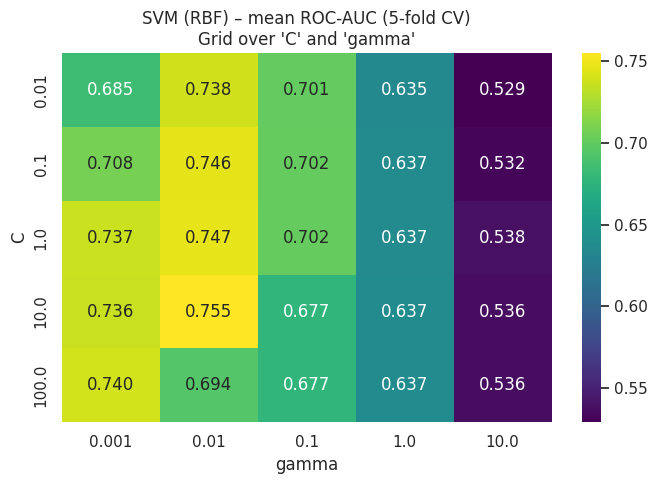

In [ ]:
# Cell 34
# We visualise the validation surface as a heatmap: 'C' vs 'gamma' -> mean AUC
# For a nice heatmap, we pivot the results into a matrix:
# Rows = 'C', Columns = 'gamma', Values = 'mean_auc'
heatmap_df = svm_results_df.pivot(
    index="C",
    columns="gamma",
    values="mean_auc")

plt.figure(figsize=(7, 5))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap="viridis")
plt.title("SVM (RBF) – mean ROC-AUC (5-fold CV)\nGrid over 'C' and 'gamma'")
plt.xlabel("gamma")
plt.ylabel("C")
plt.tight_layout()
plt.show()

**Results**:

The grid search over `C` amd `gamma` for the RBF-kernel SVM shows a clear pattern in model performance:

* The effect of `gamma` (kernel width):  
  * A very low `gamma` (= 0.001) leads to relatively low or moderate AUC (≈ 0.69–0.74), indicating an overly smooth decision boundary that underfits the data.
  * An intermediate `gamma` (= 0.01) consistently performs best across different values of `C`:
    * e.g., `C` = 10, `gamma` = 0.01 -> AUC ≈ 0.755 (best combination),
    * while `C` = 0.01–1, `gamma` = 0.01 all give AUC around 0.75. This suggests that a moderate kernel width provides a good balance between flexibility and smoothness.
  * A high `gamma` (= 1 or 10) yields very poor performance (AUC ≈ 0.53–0.64), which is typical overfitting behaviour. The kernel becomes too “narrow” and the decision boundary overreacts to individual data points.

* The effect of `C` (regularisation strength):  
  * For a good `gamma` value (e.g., = 0.01), an increasing `C` from 0.01 -> 1 -> 10 slightly improves performance (AUC from ≈ 0.738 to 0.755), but increasing `C` further to 100 does not help and even hurts performance (AUC drops to ≈ 0.69). This indicates that too strong regularisation (a very low `C`) underfits, while too weak regularisation (a very high `C`) overfits or becomes unstable. A moderate `C` (around 10) is a good compromise.

The best SVM (RBF) configuration in our grid is:
* `C` = 10,
* `gamma` = 0.01

with a mean 5-fold CV ROC-AUC of 0.755.

Comparison with other models:
* Baseline LR: 0.769
* The best L1 LR: 0.785
* The best L2 LR: 0.780
* The best polynomial LR: 0.779
* The best decision tree classifier: 0.707
* The best random forest model: 0.789
* The best gradient boosting model: 0.782
* The best XGBoost model: 0.786

Thus, the non-linear RBF SVM performs noticeably worse than the tree ensembles and also worse than the tuned logistic regression models. This suggests that after proper feature scaling, simpler linear models and tree-based ensembles extract the signal in this ICU mortality dataset more effectively than an RBF SVM.

### 5.2 The `k`-nearest neighbours model (`k`-NN)

The `k`-nearest neighbours model is a simple, instance-based method: to classify a new patient, it looks at the labels of the `k` most similar patients in the training set and makes a prediction based on their labels.

Key hyperparameters:
* `n_neighbors` (`k`): The number of neighbours considered.  
  * A very low `k` (e.g., 1–3) can overfit and be very noisy.  
  * High `k`s yield smoother predictions but may underfit.
* `weights`:
  * `"uniform"`: all `k` neighbours contribute equally.
  * `"distance"`: closer neighbours are given higher weight, which can sometimes improve performance.

Because the `k`-NN model uses distances in feature space, feature scaling is crucial. Therefore, we use the standardised feature matrix `X_scaled` (mean 0, unit variance) from earlier.


In [ ]:
# Cell 35
# First, we import the 'KNeighborsClassifier'.
from sklearn.neighbors import KNeighborsClassifier


# Hyperparameter tuning for 'k'-NN ('k', 'weights')

# We use:
# - 'X_scaled' for standardised features (very important for 'k'-NN)
# - 'y': original labels (1/2), which 'k'-NN can handle as class labels.

# We define a small grid of hyperparameters:
# - 'n_neighbors' ('k'): from small to moderately large
# - 'weights': 'uniform' (all neighbours equal) vs 'distance'
# (closer neighbours have more influence)
k_values = [3, 5, 7, 9, 15, 25]
weight_options = ['uniform', 'distance']
knn_results = []

print("k-nearest neighbours (5-fold CV, ROC-AUC):\n")

for k in k_values:
    for w in weight_options:
        # We define the 'k'-NN classifier with the current 'k' and 'weights'.
        knn_clf = KNeighborsClassifier(
            n_neighbors=k,
            weights=w)

        # We evaluate the model using a 5-fold cross-validation and the ROC-AUC.
        scores = cross_val_score(
            knn_clf,
            X_scaled,   # is used because 'k'-NN relies on distances between points.
            y,          # labels (1/2)
            cv=5,
            scoring='roc_auc')

        mean_auc = scores.mean()
        std_auc = scores.std()

        knn_results.append({
            "k": k,
            "weights": w,
            "mean_auc": mean_auc,
            "stdev_auc": std_auc})
        print(f"k = {k:2d}, weights = {w:8s} | "
            f"mean AUC = {mean_auc:.3f} | stdev = {std_auc:.3f}")

# We put results into a DataFrame and find the best configuration.
knn_results_df = pd.DataFrame(knn_results)
best_row_knn = knn_results_df.loc[knn_results_df["mean_auc"].idxmax()]
best_k = int(best_row_knn["k"])
best_weights = best_row_knn["weights"]
best_auc_knn = best_row_knn["mean_auc"]

# We print the results.
print("\nThe best 'k'-NN model (5-fold CV ROC-AUC):")
print(f"k = {best_k}, weights = {best_weights} "
    f"-> mean ROC-AUC = {best_auc_knn:.3f}")

k-nearest neighbours (5-fold CV, ROC-AUC):

k =  3, weights = uniform  | mean AUC = 0.614 | stdev = 0.058
k =  3, weights = distance | mean AUC = 0.618 | stdev = 0.063
k =  5, weights = uniform  | mean AUC = 0.628 | stdev = 0.060
k =  5, weights = distance | mean AUC = 0.636 | stdev = 0.065
k =  7, weights = uniform  | mean AUC = 0.659 | stdev = 0.064
k =  7, weights = distance | mean AUC = 0.662 | stdev = 0.065
k =  9, weights = uniform  | mean AUC = 0.666 | stdev = 0.062
k =  9, weights = distance | mean AUC = 0.671 | stdev = 0.062
k = 15, weights = uniform  | mean AUC = 0.685 | stdev = 0.071
k = 15, weights = distance | mean AUC = 0.687 | stdev = 0.074
k = 25, weights = uniform  | mean AUC = 0.705 | stdev = 0.079
k = 25, weights = distance | mean AUC = 0.707 | stdev = 0.080

The best 'k'-NN model (5-fold CV ROC-AUC):
k = 25, weights = distance -> mean ROC-AUC = 0.707


In [ ]:
# Cell 36
# We display the best performing models.
display(knn_results_df.sort_values("mean_auc", ascending=False).head(10))

,k,weights,mean_auc,stdev_auc
11,25,distance,0.706694,0.080400
10,25,uniform,0.705051,0.078922
9,15,distance,0.687106,0.074050
8,15,uniform,0.684906,0.071043
7,9,distance,0.671037,0.061599
6,9,uniform,0.665773,0.062104
5,7,distance,0.661679,0.064964
4,7,uniform,0.659301,0.063808
3,5,distance,0.635541,0.064512
2,5,uniform,0.627852,0.060154


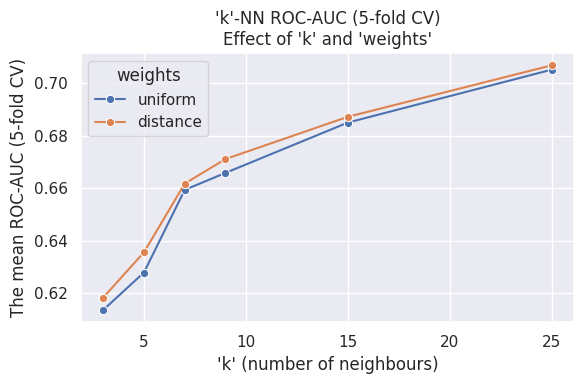

In [ ]:
# Cell 37
# We visualise the mean AUC vs 'k' for each weighting scheme.
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=knn_results_df,
    x="k",
    y="mean_auc",
    hue="weights",
    marker="o")
plt.title("'k'-NN ROC-AUC (5-fold CV)\nEffect of 'k' and 'weights'")
plt.xlabel("'k' (number of neighbours)")
plt.ylabel("The mean ROC-AUC (5-fold CV)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Results**:

The grid search over `k` (number of neighbours) and the weighting scheme (`"uniform"` vs `"distance"`) shows a clear trend: For low `k`s (e.g., `k` = 3 or `k` = 5), performance is rather poor. The AUC is only around 0.614–0.636, indicating a very noisy classifier that is sensitive to local fluctuations in the training data. As we increase `k`, the ROC-AUC gradually improves:
* `k` = 7–9 -> AUC ≈ 0.659–0.671
* `k` = 15 -> AUC ≈ 0.685–0.687
* `k` = 25 -> AUC ≈ 0.705–0.707 (best setting)

This is consistent with the idea that a larger neighbourhood smooths the decision boundary and reduces variance.

The choice of `weights` has only a minor effect:
* `"distance"` is slightly better than `"uniform"` for low `k`s, but the difference is small (around 0.01 AUC).
* At `k` = 25, both weighting schemes perform essentially identically (AUC ≈ 0.706–0.707).

The best `k`-NN model configuration in our grid is:

* `k = 25`, `weights = 'distance'`

with a mean 5-fold CV ROC-AUC of 0.707.

Comparison with the other models:

* Baseline logistic regression: AUC ≈ 0.769
* The best L1-regularised LR: AUC ≈ 0.785
* The best L2-regularised LR: AUC ≈ 0.780
* The best polynomial LR: AUC ≈ 0.779
* The best decision tree classifier : AUC ≈ 0.707
* The best random forest model: AUC ≈ 0.789
* The best gradient boosting model: AUC ≈ 0.782
* The best XGBoost model: AUC ≈ 0.781
* The best SVM (RBF): AUC ≈ 0.750
* And now, the best `k`-NN model: AUC ≈ 0.707

Thus, even after tuning, the `k`-NN clearly underperforms the tree ensembles and the regularised logistic regression models on this dataset. This suggests that a simple distance-based method is not flexible enough (or too sensitive to the high-dimensional feature space) to capture the structure of the ICU mortality data as well as the other models.

### 5.3 The naive Bayes model

The naive Bayes model is a simple probabilistic classifier based on Bayes' theorem with a strong independence assumption between features. For continuous features, the `GaussianNB` implementation in scikit-learn assumes that each feature follows a Gaussian distribution within each class.

The main hyperparameter is `var_smoothing`, which is a small value added to the variance of each feature to improve numerical stability and avoid issues when variances are extremely low. Larger `var_smoothing` values result in more smoothing.

We evaluate `GaussianNB` on a small grid of `var_smoothing` values using
5-fold cross-validation and the ROC-AUC as our performance measure.
We use the standardised features `X_scaled`.

In [ ]:
# Cell 38
# First, we import the model.
from sklearn.naive_bayes import GaussianNB

# Parameter tuning for Gaussian Naive Bayes ('var_smoothing')

# We use:
# - 'X_scaled': for standardised features
# - 'y': original labels (1/2)
# We define a range of 'var_smoothing' values on a logarithmic scale.
# 'var_smoothing' is typically around 1e-9 by default.
var_smoothing_values = np.logspace(-12, -6, 7)  # from 1e-12 to 1e-6
nb_results = []
print("GaussianNB (5-fold CV, ROC-AUC):\n")

for vs in var_smoothing_values:
    nb_clf = GaussianNB(var_smoothing=vs)
    # We evaluate the model using a 5-fold cross-validation and the ROC-AUC.
    scores = cross_val_score(
        nb_clf,
        X_scaled,
        y,
        cv=5,
        scoring='roc_auc')

    mean_auc = scores.mean()
    std_auc = scores.std()

    nb_results.append({
        "var_smoothing": vs,
        "mean_auc": mean_auc,
        "stdev_auc": std_auc})

    print(f"var_smoothing = {vs:.1e} | "
        f"mean AUC = {mean_auc:.3f} | stdev = {std_auc:.3f}")

# We put the results into a DataFrame and find the best setting
nb_results_df = pd.DataFrame(nb_results)

best_row_nb = nb_results_df.loc[nb_results_df["mean_auc"].idxmax()]
best_vs = best_row_nb["var_smoothing"]
best_auc_nb = best_row_nb["mean_auc"]

# We print the results.
print("\nThe best GaussianNB model (5-fold CV ROC-AUC):")
print(f"var_smoothing = {best_vs:.1e} "
    f"-> mean ROC-AUC = {best_auc_nb:.3f}")

GaussianNB (5-fold CV, ROC-AUC):

var_smoothing = 1.0e-12 | mean AUC = 0.728 | stdev = 0.037
var_smoothing = 1.0e-11 | mean AUC = 0.728 | stdev = 0.037
var_smoothing = 1.0e-10 | mean AUC = 0.729 | stdev = 0.036
var_smoothing = 1.0e-09 | mean AUC = 0.729 | stdev = 0.036
var_smoothing = 1.0e-08 | mean AUC = 0.729 | stdev = 0.036
var_smoothing = 1.0e-07 | mean AUC = 0.729 | stdev = 0.036
var_smoothing = 1.0e-06 | mean AUC = 0.729 | stdev = 0.036

The best GaussianNB model (5-fold CV ROC-AUC):
var_smoothing = 1.0e-08 -> mean ROC-AUC = 0.729


In [ ]:
# Cell 39
# We display the best performing models.
display(nb_results_df.sort_values("mean_auc", ascending=False))

,var_smoothing,mean_auc,stdev_auc
4,1.000000e-08,0.729369,0.035994
5,1.000000e-07,0.729327,0.035840
3,1.000000e-09,0.729306,0.036034
6,1.000000e-06,0.729306,0.035837
2,1.000000e-10,0.729221,0.035969
1,1.000000e-11,0.728015,0.036731
0,1.000000e-12,0.727867,0.036696


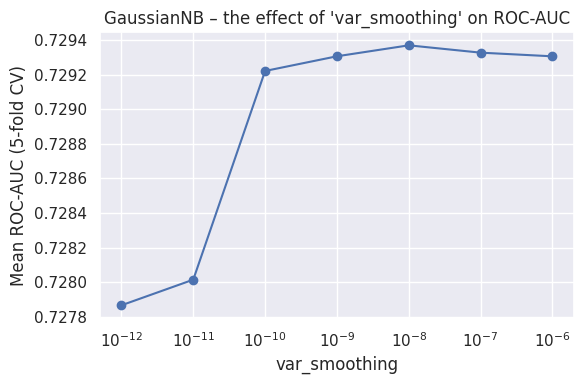

In [ ]:
# Cell 40
# We visualise the mean AUC vs 'var_smoothing' (on a log scale).
plt.figure(figsize=(6, 4))
plt.semilogx(
    nb_results_df["var_smoothing"],
    nb_results_df["mean_auc"],
    marker="o")
plt.xlabel("var_smoothing")
plt.ylabel("Mean ROC-AUC (5-fold CV)")
plt.title("GaussianNB – the effect of 'var_smoothing' on ROC-AUC")
plt.grid(True)
plt.tight_layout()
plt.show()

**Results**:

The validation curve for the Gaussian naive Bayes model shows that the hyperparameter `var_smoothing` has almost no impact on performance in this range. Across `var_smoothing` values from 1e-12 to 1e-6, the mean 5-fold ROC-AUC stays very stable around 0.728–0.729, with a standard deviation of ≈ 0.036–0.037. The best configuration in this grid is `var_smoothing` = 1e-8 with a mean ROC-AUC of 0.729, but the difference compared to other values is negligible. This indicates that the model is robust to the exact choice of `var_smoothing` in this range, and that overall performance is mainly limited by the Naive Bayes assumptions (feature independence and Gaussian likelihoods) rather than by this numerical stabilisation parameter.

In terms of overall performance, the GaussianNB model (AUC ≈ 0.729) is clearly inferior to the best-performing models:
* The best L2-regularised LR: AUC ≈ 0.780
* The best random forest model: AUC ≈ 0.789
* The best gradient boosting model: AUC ≈ 0.782
* The best XGBoost model: AUC ≈ 0.781

but slightly better than simpler distance-based methods like the `k`-NN model (best AUC ≈ 0.707). Therefore, it serves as a reasonable simple probabilistic baseline, but not as the best model for this ICU mortality prediction task.

# 6. Model performance comparison

### 6.1 Results

In this subsection, we compare the final models using two complementary evaluation approaches. First, we compute the 5-fold cross-validated ROC-AUC for each model to obtain a robust estimate of its generalisable performance. Second, we evaluate all models on an untouched 20% test holdout to obtain an unbiased assessment of their predictive ability. For the test set, we also compute and visualise the ROC curves.

Models that require feature scaling (such as logistic regression, SVM, `k`-NN, GaussianNB) are evaluated using the standardised feature matrix, while tree-based models (decision tree, random forest, gradient boosting, XGBoost) are trained on the original unscaled features. All models are instantiated with their best hyperparameters identified in the previous tuning steps.

The following code cells implement the final models, compute their cross-validated AUC values, and generate the test-set ROC curves for a direct and consistent comparison.

In [ ]:
# Cell 41
# We prepare the binary outcome labels and create the stratified train/test split.
from sklearn.model_selection import train_test_split


# Step 1: We prepare binary labels and the train/test split.
# We recode the original outcome 'y' (values {1, 2}) into a binary label:
#   '0' = survivors, '1' = non-survivors (7-day mortality).
y_bin = (y == 2).astype(int)

print("Unique labels in y:", sorted(y.unique()))
print("Unique labels in y_bin:", sorted(y_bin.unique()))

# We use both 'X' (the original features) and 'X_scaled' (the standardised features).
# Some models, such as logistic regression, SVM, 'k'-NN, and naive Bayes, will use 'X_scaled',
# while tree-based models, such as the decision tree, random forest, gradient boosting, and XGBoost,
# will use 'X'.
X_train, X_test, X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(
    X,
    X_scaled,
    y_bin,
    test_size=0.2,
    stratify=y_bin,
    random_state=42)

Unique labels in y: [np.float64(1.0), np.float64(2.0)]
Unique labels in y_bin: [np.int64(0), np.int64(1)]


Next, we define the final model and the 5-fold CV AUC summary table. We selected a group of "final" comparison candidates:
* Logistic regression (L2-tuned, best `C` = 0.0268)
* Random forest (our best hyperparameters)
* Gradient boosting (best)
* XGBoost (best)
* SVM (RBF, best `C` and `gamma`)
* `k`-NN (best `k` = 25)
* Gaussian naive Bayes (best `var_smoothing`)
* Decision tree (best `depth` = 4, `min_samples_leaf` = 5)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np


In [ ]:
# Cell 42
# Step 2: We define the final models to compare.
# We take the best hyperparameters from the previous sections:
best_C_l2 = 0.0268  # The best `C` value from L2-regularised logistic regression tuning

models_scaled = { # Models that require standardised features ('X_scaled')
    "Logistic L2 ('C' = 0.0268)": LogisticRegression(
        penalty="l2",
        C=best_C_l2,
        solver="lbfgs",
        max_iter=1000),
    "SVM RBF ('C' = 10, 'γ' = 0.01)": SVC(
        kernel="rbf",
        C=10.0,
        gamma=0.01,
        probability=True),  # This enables 'predict_proba', which is needed for ROC curves.
    "k-NN ('k' = 25)": KNeighborsClassifier(
        n_neighbors=25,
        weights="uniform"),
    "GaussianNB": GaussianNB(
        var_smoothing=1e-8)}

# For tree-based models, which do not require feature scaling ('X'):
models_tree = {"Decision tree": DecisionTreeClassifier(
        max_depth=4,
        min_samples_leaf=5,
        random_state=42),
    "Random forest": RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42),
    "Gradient boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=1,
        random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42)}

# Step 3: We compute the 5-fold CV ROC-AUC for each model.
results = []
print("5-fold CV ROC-AUC for each final model:\n")

# Models evaluated using scaled features ('X_scaled'):
for name, model in models_scaled.items():
    scores = cross_val_score(
        model,
        X_scaled,   # scaled features
        y_bin,      # binary labels
        cv=5,
        scoring="roc_auc")
    mean_auc = scores.mean()
    std_auc = scores.std()
    results.append({
        "Model": name,
        "Type": "scaled",
        "Mean CV AUC": mean_auc,
        "Stdev CV AUC": std_auc})
    print(f"{name:25s} | mean AUC = {mean_auc:.3f} | stdev = {std_auc:.3f}")

# Models evaluated using original (unscaled) features ('X'):
for name, model in models_tree.items():
    scores = cross_val_score(
        model,
        X,          # original features
        y_bin,
        cv=5,
        scoring="roc_auc")
    mean_auc = scores.mean()
    std_auc = scores.std()
    results.append({
        "Model": name,
        "Type": "tree",
        "Mean CV AUC": mean_auc,
        "Stdev CV AUC": std_auc})
    print(f"{name:25s} | mean AUC = {mean_auc:.3f} | stdev = {std_auc:.3f}")

5-fold CV ROC-AUC for each final model:

Logistic L2 ('C' = 0.0268) | mean AUC = 0.780 | stdev = 0.031
SVM RBF ('C' = 10, 'γ' = 0.01) | mean AUC = 0.755 | stdev = 0.043
k-NN ('k' = 25)           | mean AUC = 0.705 | stdev = 0.079
GaussianNB                | mean AUC = 0.729 | stdev = 0.036
Decision tree             | mean AUC = 0.703 | stdev = 0.009
Random forest             | mean AUC = 0.787 | stdev = 0.016
Gradient boosting         | mean AUC = 0.782 | stdev = 0.023
XGBoost                   | mean AUC = 0.786 | stdev = 0.029


In [ ]:
# Cell 43
# We create a summary DataFrame and sort by the mean CV AUC.
summary_df = pd.DataFrame(results).sort_values("Mean CV AUC", ascending=False)
display(summary_df)

,Model,Type,Mean CV AUC,Stdev CV AUC
5,Random forest,tree,0.787268,0.016394
7,XGBoost,tree,0.785624,0.029095
6,Gradient boosting,tree,0.782261,0.023219
0,Logistic L2 ('C' = 0.0268),scaled,0.780235,0.030682
1,"SVM RBF ('C' = 10, 'γ' = 0.01)",scaled,0.755033,0.042803
3,GaussianNB,scaled,0.729369,0.035994
2,k-NN ('k' = 25),scaled,0.705051,0.078922
4,Decision tree,tree,0.702797,0.008972


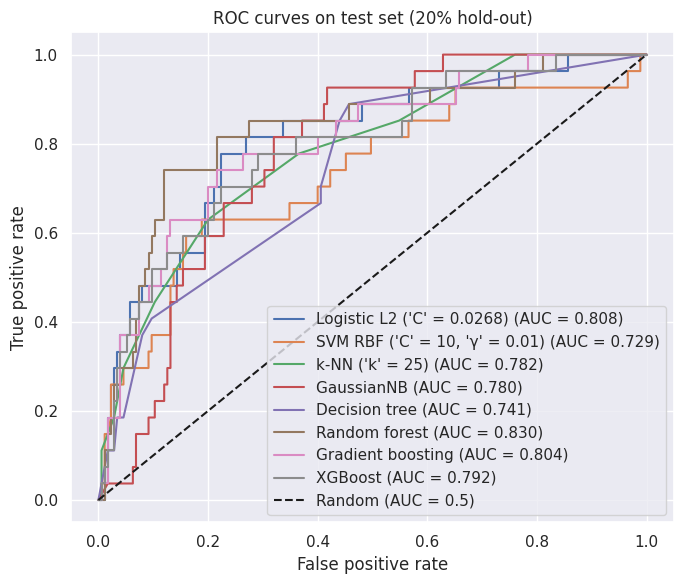

In [ ]:
# Cell 44
# Step 4: We plot the ROC curves on the held-out test set.
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize=(7, 6))
roc_results = []  # to store test-set AUC for each model

# 1) Models that use scaled features:
for name, model in models_scaled.items():
    # To fit on the training split:
    model.fit(X_scaled_train, y_train)

    # we get predicted scores on the test split.
    # For most models, we use 'predict_proba'; for SVM, we can use 'predict_proba' too
    # because we set 'probability'=True.
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_scaled_test)[:, 1]
    else:
        # Fallback: we use 'decision_function', if available.
        y_score = model.decision_function(X_scaled_test)

    # We compute the ROC curve and the AUC.
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_test = roc_auc_score(y_test, y_score)
    roc_results.append({"Model": name, "Test AUC": auc_test})

    # We plot the ROC curve.
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_test:.3f})")

# 2) Models that use original features (tree-based):
for name, model in models_tree.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_test = roc_auc_score(y_test, y_score)
    roc_results.append({"Model": name, "Test AUC": auc_test})
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_test:.3f})")

# We plot a random classifier line.
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves on test set (20% hold-out)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 45
# We turn the ROC test results into a small DataFrame.
roc_summary_df = pd.DataFrame(roc_results).sort_values("Test AUC", ascending=False)
display(roc_summary_df)

,Model,Test AUC
5,Random forest,0.829630
0,Logistic L2 ('C' = 0.0268),0.807619
6,Gradient boosting,0.804021
7,XGBoost,0.791958
2,k-NN ('k' = 25),0.782222
3,GaussianNB,0.779788
4,Decision tree,0.741376
1,"SVM RBF ('C' = 10, 'γ' = 0.01)",0.729418


The ROC curves on the held-out test set confirm the relative ranking of model performance observed during cross-validation, with tree ensembles (random forest, XGBoost, gradient boosting) achieving the highest AUC and simpler models like `k`-NN and GaussianNB performing worse.

### 6.2 Interpretation and discussion


The table above (# Cell 45) summarises the 5-fold cross-validated ROC-AUC for all final models:
* The random Forest model performs best overall, with a mean CV AUC of 0.787 and a relatively low standard deviation (≈ 0.016), indicating both strong and stable performance across folds.
* The XGBoost model follows closely, with a mean CV AUC of 0.786 (stdev ≈ 0.029).
* The gradient boosting and L2-regularised logistic regression are next, with mean CV AUCs of 0.782 (stdev ≈ 0.023) and 0.780 (stdev ≈ 0.031), respectively. Despite being a simple linear model, logistic regression captures substantial predictive signal once features are standardised and regularised.
* The Gaussian naive Bayes model achieves a moderate CV AUC of 0.729: better than purely distance-based methods, but below the tree ensembles and logistic regression. This reflects its strong independence and Gaussian assumptions.
* The SVM with RBF kernel reaches a mean CV AUC of 0.755, which is better than the naive Bayes model and the `k`-NN model, but below the top-performing models.
* The `k`-NN (`k` = 25) and the single decision tree model perform worst, with mean CV AUCs of 0.705 and 0.703, respectively, with `k`-NN showing high variability across folds (stdev ≈ 0.079).

Overall, the top-performing group consists of the random forest model, the XGBoost model, the gradient boosting model, and the L2-regularised logistic regression, all with mean CV AUCs around 0.78. Among these, the random forest model has the highest mean CV AUC and low variance, making it the natural candidate for the “best” model in terms of predictive performance, while logistic regression remains attractive if interpretability is a priority.

**Which models performed best and why?**

Across all models, the best 5-fold CV ROC-AUC scores were obtained by the tree ensembles and the regularised logistic regression model:

* The random forest model: mean CV AUC ≈ 0.787
* The XGBoost model: mean CV AUC ≈ 0.786
* The gradient boosting model: mean CV AUC ≈ 0.782
* The L2-regularised logistic regression: mean CV AUC ≈ 0.780

These four models form a clear top group: their AUCs are very similar, and differences are small compared to variability across folds.
* The random forest model and the boosting methods naturally model non-linear relationships and interactions between variables, and they are robust to noisy features. Bagging reduces variance, while boosting focuses iteratively on difficult cases.
* The L2-regularised logistic regression performs almost as well, indicating that the signal in this dataset is largely captured by linear combinations of features. Many clinical scores (e.g., `SOFA` components) are roughly additive, making a linear model appropriate.
* Models like the SVM (RBF), the GaussianNB model, the `k`-NN, and the decision tree lag behind due to their respective limitations: `k`-NN struggles in high dimensions, a single tree has high variance, the naive Bayes model relies on strong independence assumptions, and the SVM is sensitive to hyperparameter tuning.


**Overfitting considerations**

* The decision tree: deeper trees and low `min_samples_leaf` reduce CV AUC, while a moderately deep tree (`max_depth` = 4, `min_samples_leaf` = 5) performed best (AUC ≈ 0.703).
* The random forest model: increasing the number of trees improved performance, with modest `min_samples_leaf` = 5 without overfitting.
* The gradient boosting & XGBoost models: low learning rates (0.05) with a moderate number of trees provided best CV AUC.
* The SVM (RBF): extreme `γ` values caused under- or overfitting; a moderate `γ` (0.01) with mid-range `C` (10) yielded best results.
* The `k`-NN model: a low `k` led to noisy low-AUC models; increasing the `k` improved AUC but plateaued around 0.705 at `k` = 25.

Using 5-fold cross-validation for all hyperparameter choices reduced the risk of overfitting to a single train/test split. The small standard deviations for top models indicate stable performance across folds.

**Model interpretability**

* Logistic regression: most interpretable; coefficients can be translated to odds ratios for clinical interpretability.
* The decision tree model: interpretable but low predictive performance (AUC ≈ 0.703).
* The random forest model and the boosting models: less interpretable; hundreds of trees make explanations complex, though feature importance and SHAP values can help.
* The SVM model and the `k`-NN model: difficult to interpret; the SVM defines a boundary in high-dimensional space, the `k`-NN model uses neighbor averaging.

Given that logistic regression achieves nearly the same CV AUC as the best ensemble models (0.780 vs 0.787), it is strong for clinical decision-support where interpretability matters.

**The impact of missing data handling**

Missing data is a major issue in real-world ICU datasets, and our handling of missingness has several implications:
* Dropping highly incomplete variables: We dropped `uo_d1` because it had extremely high missingness (only 13 non-missing values out of 1010). Keeping such a variable would either force us to discard many patients or rely on almost entirely imputed values, both of which could introduce bias or noise. This choice reduces dimensionality and avoids basing predictions on a very unreliable feature.
* Dropping rows with missing outcome: We removed rows where `mort7` was missing, because the target label is essential. If missingness in the outcome is not completely random, this could introduce some selection bias, but it is unavoidable for supervised learning.
* The imputation strategy for predictors: For numerical variables, we used median imputation, which is robust to outliers and preserves the distribution better than mean imputation for skewed clinical variables (e.g. creatinine, bilirubin). For categorical variables, we used most frequent category imputation, which is simple and often reasonable when missingness is low. This allows us to retain all patients and use models that do not handle missing values natively (e.g., logistic regression, SVM, `k`-NN, maive Bayes, gradient boosting).
* Potential limitations of our imputation: We performed imputation on the full dataset before cross-validation, which can introduce a slightly optimistic bias (the imputer “sees” information from all samples). In a more rigorous pipeline, the imputer should be fitted within each training fold and then applied to the corresponding validation fold. We assumed that missingness can be adequately handled by simple median/most-frequent imputation. If data are not missing at random (e.g., sicker patients are more likely to have certain measurements taken), then imputation might distort the relationship between predictors and mortality. Some variables with moderate missingness (e.g., `MAP_d1`, `SOFA` components) were imputed rather than dropped, which is a trade-off between keeping potentially informative features and adding imputation noise.

### 6.3 Conclusion

Overall, our relatively strong model performances (AUC ≈ 0.78-0.79 for the best models) suggest that this simple imputation strategy was adequate for this assignment. However, in a real clinical deployment, more careful missing-data handling (e.g., multiple imputation, imputation within cross-validation folds, explicit modelling of missingness patterns) would be important to minimise bias and to better reflect the uncertainty associated with incomplete ICU data.